# Explaining cortical thickness development: Single-subject data

Note: Because of data protection policies, ABCD and IMAGEN data is not included in this repository and all code that display subject-level data are commented out. Please see the "_getData" notebooks for further information.

In [1]:
import sys
import os
from os.path import join
import copy
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
import matplotlib as mpl
from pingouin import ancova, pairwise_tests
import seaborn as sns
from scipy.stats import spearmanr
from IPython.display import display
from tqdm.auto import tqdm 
from joblib import Parallel, delayed

# custom functions
from scripts.templates import get_destrieux
from scripts.utils import alt_idps, alt_preds, na, replace, sel_cols, p_to_ast, rename_myelin
from scripts.plots_brain import get_parc_gifti, plot_surf_ax
from scripts.plots import plot_raincloud

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# JuSpyce
sys.path.append(os.path.dirname(join(wd, "scripts", "juspyce")))
from juspyce.api import JuSpyce
from juspyce.stats import corr, residuals, mc_correction
from juspyce.nulls import generate_null_maps

# predictor data path
predictor_dir = join(wd, "data_predictors")

# plot directory
plot_dir = join(wd, "plots", "abcd-imgn")

# ABCD directory
abcdimgn_dir = join(wd, "data_ABCD-IMGN")

# rerun dominance analyses
rerun_dominance = False

# rerun prediction generalization
rerun_transpred = False

# number of permutations
n_perm = 1000

Working directory: /Users/llotter/projects/CTdev


## Get data

### Get ABCD & IMAGEN data

In [2]:
# get ABCD data
abcd = pd.read_feather(join(abcdimgn_dir, "abcd_pred.ftr")).set_index(["idx_id", "idx_tp"])
abcd = abcd[abcd.both_tp==True]

# get IMAGEN data
imgn = pd.read_feather(join(abcdimgn_dir, "imgn_pred.ftr")).set_index(["idx_id", "idx_tp"])
imgn = imgn[imgn.tp_one!=True]

## create some lists to help iterating over the data later on

# datasets
dss = ["abcd"] + ["imgn"]*3
# timepoints
tps = ["T0", "T2", "T0", "T5", "T8"]
# datasets * timepoints
ds_tps = [("abcd", "T0"), ("abcd", "T2"), ("imgn", "T0"), ("imgn", "T5"), ("imgn", "T8")] 
# number of timepoints
n_tp = len(ds_tps)
# timespans
tss = ["T0T2", "T0T8", "T0T5", "T5T8"]
# datasets * timespans
ds_tss = [("abcd", "T0T2"), ("imgn", "T0T8"), ("imgn", "T0T5"), ("imgn", "T5T8")]
# number of timespans
n_ts = len(tss)
# rough timepoint ages
tss_age = [(10,12), (14,22), (14,19), (19,22)]
# exact timepoint ages
tss_age_exact = \
    [(np.round(df.loc[(na(), ts[:2]), "age"].mean(), 2), 
      np.round(df.loc[(na(), ts[2:]), "age"].mean(), 2)) for df, (_, ts) in zip([abcd, imgn, imgn, imgn], ds_tss)]
# mean age for each timespan
tss_age_mean = [np.round(np.mean(a),2) for a in tss_age_exact]
    
print(tss_age_exact)
print(tss_age_mean)

[(9.91, 11.96), (14.44, 22.56), (14.44, 19.0), (19.0, 22.56)]
[10.94, 18.5, 16.72, 20.78]


### Get predictor data

In [3]:
# all predictors
predictors_destrieux = pd.read_csv(join(predictor_dir, 'data_factors_destrieux.csv'), index_col=0)
predictors = list(predictors_destrieux.columns)
print("All predictors:\n", predictors)

# single-subjects analyses: significant (uncorrected) in dominance analysis and relevant
# for the age span of ABCD/IMGN (defined as rounded min and max age)
temp = JuSpyce.from_pickle(
    join(wd, "data_rutherford", "juspyce_ct_dominance_fm_500_5.pkl.gz"), verbose=False) \
        .p_predictions["dominance_total"]

# predictor maps relevant for ABCD timespan (nominal p < 0.05)
predictors_abcd = (temp < 0.05).loc[[f"Δ({i},{i+5})" for i in \
    range(int(abcd.age.round(0).min()), int(abcd.age.round(0).max()+1))]].any()
predictors_abcd = predictors_abcd[predictors_abcd==True].index.to_list()

# predictor maps relevant for IMAGEN timespan (nominal p < 0.05)
predictors_imgn = (temp < 0.05).loc[[f"Δ({i},{i+5})" for i in \
    range(int(imgn.age.round(0).min()), int(imgn.age.round(0).max()+1))]].any()
predictors_imgn = predictors_imgn[predictors_imgn==True].index.to_list()

# combined (relevant for either one)
predictors_both = [p for p in predictors if (p in predictors_abcd) | (p in predictors_imgn)]

# colors for plotting
c_full_model = np.array([0.8,0.8,0.8,1])
c_predictors_both = get_cmap("tab10")([1, 3, 4, 5, 6, 7, 8])

print(f"Single-subject predictors: \nABCD: {predictors_abcd}, \nIMGN: {predictors_imgn}, "
      f"\nboth: {predictors_both}")

All predictors:
 ['ni1-SV2A-M1-mGluR5-5HT6-CB1-GABAa-HDAC', 'ni2-5HT2a-5HT4-5HT1a-5HTT', 'ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni7-COX1', 'ni8-H3', 'ni9-D2', 'ni10-TSPO', 'ce1-Ex7-In4-Ex5-Ex4-In1', 'ce2-Oligo-Endo', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce6-Ex8-Ex6', 'ce7-In7-Ex3', 'ce8-In5', 'ce9-In8', 'ce10-Ex1', 'mr1-myelin']
Single-subject predictors: 
ABCD: ['ni4-GI-5HT1b-MU-A4B2', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8'], 
IMGN: ['ni4-GI-5HT1b-MU-A4B2', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8'], 
both: ['ni4-GI-5HT1b-MU-A4B2', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']


/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/2216617422.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_predictors_both = get_cmap("tab10")([1, 3, 4, 5, 6, 7, 8])


### Get IDPs and parcellation

In [4]:
parc_destrieux, destrieux_idps = get_destrieux()

## CT development

In [5]:
## Calculate relative CT change for IMAGEN and ABCD subjects

# storage dict
temp = dict()

# iterate timespans
for data, name in zip([abcd[abcd.both_tp==True], 
                       imgn[imgn.tp_T0T8==True],
                       imgn[imgn.tp_T0T5==True],
                       imgn[imgn.tp_T5T8==True]],
                      ["abcd_T0T2", "imgn_T0T8", "imgn_T0T5", "imgn_T5T8"]):
    
    # list of subjects
    subs = list(data.index.get_level_values("idx_id").unique())
    tps = data.tp.unique().tolist()
    print(name, tps)
    # sanity check
    if len(tps) != 2:
        print("Something wrong!")
        break
    
    # datasets at timepoint 1 and 2
    temp1 = data.loc[(subs, tps[0]), :].copy()
    temp2 = data.loc[(subs, tps[1]), :].copy()

    # dict to store CT changes
    delta_dict = dict()
    
    # iterate IDPS
    for idp in ["EstimatedTotalIntraCranialVol"] + destrieux_idps:
        
        # get CT data
        ct_T0_harm = temp1[idp+"-harm"].to_numpy()
        ct_T2_harm = temp2[idp+"-harm"].to_numpy()
        ct_T0_resc = temp1[idp+"-rescaled"].to_numpy()
        ct_T2_resc = temp2[idp+"-rescaled"].to_numpy()
        ct_T0_pred = temp1[idp+"-pred50"].to_numpy()
        ct_T2_pred = temp2[idp+"-pred50"].to_numpy()
        ct_T0_orig = temp1[idp].to_numpy()
        ct_T2_orig = temp2[idp].to_numpy()
        # calculate relative change
        ct_delta_harm = (ct_T2_harm - ct_T0_harm) / ct_T0_harm
        ct_delta_resc = (ct_T2_resc - ct_T0_resc) / ct_T0_resc
        ct_delta_pred = (ct_T2_pred - ct_T0_pred) / ct_T0_pred
        ct_delta_orig = (ct_T2_orig - ct_T0_orig) / ct_T0_orig
        
        # get Z data
        z_T0 = temp1[idp+"-z"].to_numpy()
        z_T2 = temp2[idp+"-z"].to_numpy()
        # calculate change in deviation z scores
        z_delta = z_T2 - z_T0
        
        # save
        delta_dict[idp+"-delta"] = ct_delta_harm # ComBat-GAM harmonized: now only "-delta"
        delta_dict[idp+"-delta_orig"] = ct_delta_orig # original "-delta_orig"
        delta_dict[idp+"-delta_resc"] = ct_delta_resc # rescaled by the Braincharts model "-delta_resc"
        delta_dict[idp+"-delta_pred"] = ct_delta_pred # predicted by the Braincharts model "-delta_pred"
        delta_dict[idp+"-z_delta"] = z_delta # deviation z score by the Braincharts model "-z_delta"
        
        # correct CT and Z values for ICV
        if idp != "EstimatedTotalIntraCranialVol":
            
            ct_T0_tiv = residuals(temp1["EstimatedTotalIntraCranialVol-harm"].to_numpy(), ct_T0_harm, decenter=True) 
            ct_T2_tiv = residuals(temp2["EstimatedTotalIntraCranialVol-harm"].to_numpy(), ct_T2_harm, decenter=True) 
            ct_delta_tiv = (ct_T2_tiv - ct_T0_tiv) / ct_T0_tiv 
            
            # save
            delta_dict[idp+"-delta_tiv"] = ct_delta_tiv # ComBat-GAM harmonized, residualized for TIV

    # dict to df, construct index to match on "second-tp" subjects
    delta_df = pd.DataFrame(delta_dict, index=subs, dtype=np.float32)
    delta_df = delta_df.set_index(pd.Series([name[-2:]]*len(subs)), append=True)
    delta_df.index.names = ["idx_id", "idx_tp"]

    temp[name] = delta_df

# merge to pheno dataframes
abcd = abcd.merge(temp["abcd_T0T2"], on=["idx_id", "idx_tp"], how="left")
imgn_T0T8 = imgn.merge(temp["imgn_T0T8"], on=["idx_id", "idx_tp"], how="left")[imgn.tp_T0T8==True]
imgn_T0T5 = imgn.merge(temp["imgn_T0T5"], on=["idx_id", "idx_tp"], how="left")[imgn.tp_T0T5==True]
imgn_T5T8 = imgn.merge(temp["imgn_T5T8"], on=["idx_id", "idx_tp"], how="left")[imgn.tp_T5T8==True]

# new dataframe with ct-derivatives of all subjects across studies
ct_cols = ["id", "td", "site", "age", "sex"] + temp["abcd_T0T2"].columns.to_list()
data_delta = pd.concat([
    abcd.loc[(na(), "T2"), ct_cols].assign(ds="abcd", ts="T0T2").set_index(["ds", "id", "ts"], drop=False),
    imgn_T0T8.loc[(na(), "T8"), ct_cols].assign(ds="imgn", ts="T0T8").set_index(["ds", "id", "ts"], drop=False),
    imgn_T0T5.loc[(na(), "T5"), ct_cols].assign(ds="imgn", ts="T0T5").set_index(["ds", "id", "ts"], drop=False),
    imgn_T5T8.loc[(na(), "T8"), ct_cols].assign(ds="imgn", ts="T5T8").set_index(["ds", "id", "ts"], drop=False),
])
#display(data_delta)

# new dataframe with cross-sectional data for sanity checks (only subjects that have longitudinal data)
ct_cols = ["id", "tp", "td", "site", "age", "sex"] + [c for c in imgn.columns if (("_thickness" in c) | ("EstimatedTotalIntraCranialVol" in c)) & ("delta" not in c)]
data_cross = pd.concat([
    abcd.loc[(data_delta[data_delta.ds=="abcd"].id.unique(), na()), ct_cols].assign(ds="abcd").set_index(["ds", "id", "tp"], drop=False),
    imgn.loc[(data_delta[data_delta.ds=="imgn"].id.unique(), na()), ct_cols].assign(ds="imgn").set_index(["ds", "id", "tp"], drop=False),
])
#display(data_cross)

abcd_T0T2 ['T0', 'T2']
imgn_T0T8 ['T0', 'T8']
imgn_T0T5 ['T0', 'T5']
imgn_T5T8 ['T5', 'T8']


/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/942516427.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abcd = abcd.merge(temp["abcd_T0T2"], on=["idx_id", "idx_tp"], how="left")
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/942516427.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abcd = abcd.merge(temp["abcd_T0T2"], on=["idx_id", "idx_tp"], how="left")
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/942516427.py:79: PerformanceWarning: DataFrame is highly fragmented.

### Plot mean brains

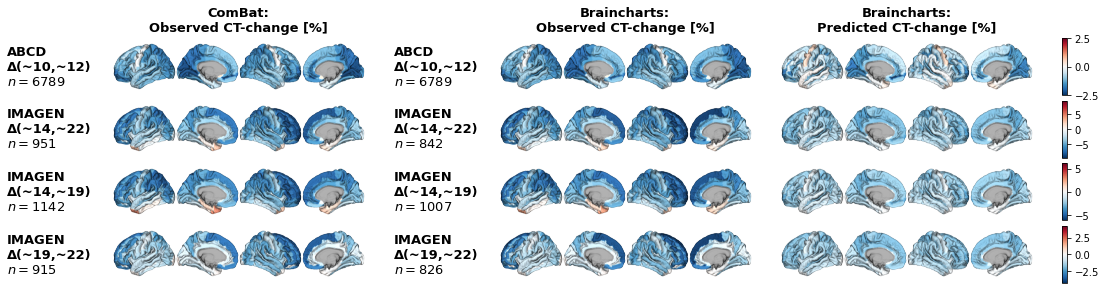

In [6]:
# Plot mean CT change values across studied timespans on surfaces 

# source data
source_data = {}

fig, axes = plt.subplots(4,6, figsize=(19,4.5), gridspec_kw=dict(hspace=0.1, wspace=0.2, 
                                                                 width_ratios=(0.3,1,0.3,1,1,0.02)))

# iterate timespans
for r, ds_ts, ts_age in zip(range(4), ds_tss, tss_age):
    
    # dataset and timespan
    ds = ds_ts[0]
    ts = ds_ts[1]
    
    # dfs with observed CT change and CT change as predicted by the Braincharts model
    # ComBat
    temp1 = data_delta.loc[(ds, na(), ts), alt_idps("-delta", destrieux_idps)].dropna()
    # Braincharts-rescaled
    temp2 = data_delta.loc[(ds, na(), ts), alt_idps("-delta_resc", destrieux_idps)].dropna()
    # Predicted
    temp3 = data_delta.loc[(ds, na(), ts), alt_idps("-delta_pred", destrieux_idps)].dropna()
    
    # limits for plotting
    lim = np.max([temp1.mean("rows").abs().max(), temp2.mean("rows").abs().max(), temp3.mean("rows").abs().max()]) * 100
    
    # plot observed and predicted CT change
    for c, data, title in zip([1,3,4], [temp1, temp2, temp3], ["ComBat:\nObserved", "Braincharts:\nObserved", "Braincharts:\nPredicted"]):
        
        # brains
        lh, rh = get_parc_gifti(data.mean("rows") * 100)
        plot_surf_ax(ax=axes[r,c], fig=fig, lh=lh, rh=rh, c="RdBu_r", c_lims=(-lim, lim))
        
        # legend
        norm = mpl.colors.Normalize(-lim, lim)
        sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
        sm.set_array([])
        cb = plt.colorbar(sm, cax=axes[r,-1])
        axes[0,c].set_title(title+" CT-change [%]", weight="semibold", pad=10, size=13)
        
        # labels
        if c in [1,3]:
            axes[r,c-1].annotate(
                f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\nΔ(~{ts_age[0]},~{ts_age[1]})\n$n={data.shape[0]}$", xy=(0,0.5), 
                va="center", xycoords="axes fraction", weight="semibold", size=13
            )
            axes[r,c-1].set_axis_off()
            
        # source
        source_data[ds + "_" + title.replace(":\n", "")] = pd.Series(
            (data.mean("rows") * 100).values,
            index=predictors_destrieux.index
        )

# save
fig.savefig(join(plot_dir, "dev_ct_deltabrains.png"), dpi=250, bbox_inches="tight")
pd.concat(source_data, axis=1).to_csv(join(plot_dir, "dev_ct_deltabrains_source.csv"))

### Look at site effects

#### Cross-sectional

In [7]:
# compare CT between sites

site_eff_bl = dict()

source_data = {}

# iterate datasets
for ds, tp in ds_tps:
    # get data
    temp = data_cross.loc[(ds, na(), tp), :]
    
    temp_dict = dict()
    
    # iterate IDPS
    for idp in tqdm(destrieux_idps, desc=tp):
        # iterate observed CT data, site-adjusted CT data, and deviation scores
        for suff, name in zip(["", "-harm", "-z"], ["", "(ComBat)", "(deviation Z)"]):
            
            # calculate ANCOVA
            anc = ancova(
                data=temp,
                dv=idp + suff,
                between="site",
                covar=["age", "sex", f"EstimatedTotalIntraCranialVol{suff}"]
            )
            
            # store data
            temp_anc = anc.iloc[0,1:]
            temp_anc["df"] = (anc.DF.values[0], anc.DF.values[-1])
            temp_anc["F"] = temp_anc["F"].round(2)
            temp_anc["np2"] = temp_anc["np2"].round(2)
            temp_anc["p-unc"] = "< 0.001" if temp_anc["p-unc"] < 0.001 else f"{temp_anc['p-unc']:.03f}"
            temp_anc = temp_anc[["F", "df", "p-unc", "np2"]]
            temp_dict[f"{idp.replace('_thickness', '')} {name}"] = temp_anc
            
            # source
            source_data[ds, tp, f"{idp.replace('_thickness', '')} {name}"] = \
                temp.groupby("site")[idp + suff].describe()
    
    # finalize
    site_eff_bl[("ABCD" if ds=="abcd" else "IMAGEN", tp)] = pd.DataFrame.from_dict(temp_dict, orient="index")
site_eff_bl = pd.concat(site_eff_bl, axis=1)

# source
pd.concat(source_data, names=["dataset", "timepoint", "region (analysis)"]) \
    .to_csv(join(abcdimgn_dir, "site_effects_cross_source.csv"))

# save
site_eff_bl.to_csv(join(abcdimgn_dir, "site_effects_cross.csv"))
site_eff_bl

T0:   0%|          | 0/148 [00:00<?, ?it/s]

T2:   0%|          | 0/148 [00:00<?, ?it/s]

T0:   0%|          | 0/148 [00:00<?, ?it/s]

T5:   0%|          | 0/148 [00:00<?, ?it/s]

T8:   0%|          | 0/148 [00:00<?, ?it/s]

ABCD                             \
                                           T0                              
                                            F          df    p-unc   np2   
lh_G&S_frontomargin                     14.99  (20, 6765)  < 0.001  0.04   
lh_G&S_frontomargin (ComBat)             0.66  (20, 6765)    0.867  0.00   
lh_G&S_frontomargin (deviation Z)       24.25  (20, 6765)  < 0.001  0.07   
lh_G&S_occipital_inf                    11.58  (20, 6765)  < 0.001  0.03   
lh_G&S_occipital_inf (ComBat)            0.41  (20, 6765)    0.991  0.00   
...                                       ...         ...      ...   ...   
rh_S_temporal_sup (ComBat)               0.39  (20, 6765)    0.993  0.00   
rh_S_temporal_sup (deviation Z)         28.52  (20, 6765)  < 0.001  0.08   
rh_S_temporal_transverse                 1.90  (20, 6765)    0.009  0.01   
rh_S_temporal_transverse (ComBat)        0.34  (20, 6765)    0.998  0.00   
rh_S_temporal_transverse (deviation Z)  15.43  (20, 6765)  < 0.001  0.04   

                                                                          \
                                           T2                              
                                            F          df    p-unc   np2   
lh_G&S_frontomargin                     13.78  (20, 6765)  < 0.001  0.04   
lh_G&S_frontomargin (ComBat)             0.64  (20, 6765)    0.886  0.00   
lh_G&S_frontomargin (deviation Z)       23.25  (20, 6765)  < 0.001  0.06   
lh_G&S_occipital_inf                     9.65  (20, 6765)  < 0.001  0.03   
lh_G&S_occipital_inf (ComBat)            0.77  (20, 6765)    0.751  0.00   
...                                       ...         ...      ...   ...   
rh_S_temporal_sup (ComBat)               0.56  (20, 6765)    0.942  0.00   
rh_S_temporal_sup (deviation Z)         29.46  (20, 6765)  < 0.001  0.08   
rh_S_temporal_transverse                 1.42  (20, 6765)    0.100  0.00   
rh_S_temporal_transverse (ComBat)        0.11  (20, 6765)    1.000  0.00   
rh_S_temporal_transverse (deviation Z)  15.51  (20, 6765)  < 0.001  0.04   

                                       IMAGEN                            \
                                           T0                             
                                            F         df    p-unc   np2   
lh_G&S_frontomargin                     10.78  (7, 1284)  < 0.001  0.06   
lh_G&S_frontomargin (ComBat)            15.57  (7, 1284)  < 0.001  0.08   
lh_G&S_frontomargin (deviation Z)       24.27  (7, 1129)  < 0.001  0.13   
lh_G&S_occipital_inf                     8.33  (7, 1284)  < 0.001  0.04   
lh_G&S_occipital_inf (ComBat)            4.17  (7, 1284)  < 0.001  0.02   
...                                       ...        ...      ...   ...   
rh_S_temporal_sup (ComBat)               7.96  (7, 1284)  < 0.001  0.04   
rh_S_temporal_sup (deviation Z)          8.94  (7, 1129)  < 0.001  0.05   
rh_S_temporal_transverse                 3.33  (7, 1284)    0.002  0.02   
rh_S_temporal_transverse (ComBat)        1.09  (7, 1284)    0.365  0.01   
rh_S_temporal_transverse (deviation Z)   5.56  (7, 1129)  < 0.001  0.03   

                                                                         \
                                           T5                             
                                            F         df    p-unc   np2   
lh_G&S_frontomargin                     46.52  (7, 1248)  < 0.001  0.21   
lh_G&S_frontomargin (ComBat)             8.61  (7, 1248)  < 0.001  0.05   
lh_G&S_frontomargin (deviation Z)       62.00  (7, 1113)  < 0.001  0.28   
lh_G&S_occipital_inf                    16.26  (7, 1248)  < 0.001  0.08   
lh_G&S_occipital_inf (ComBat)            4.43  (7, 1248)  < 0.001  0.02   
...                                       ...        ...      ...   ...   
rh_S_temporal_sup (ComBat)               4.59  (7, 1248)  < 0.001  0.03   
rh_S_temporal_sup (deviation Z)         28.69  (7, 1113)  < 0.001  0.15   
rh_S_temporal_transverse           

#### Longitudinal

In [8]:
# compare CT change between sites

site_eff_bl = dict()

source_data = {}

for ds, ts in ds_tss:
    
    temp = data_delta.loc[(ds, na(), ts), :].copy()
    df = abcd if ds=="abcd" else imgn
    temp["age_diff"] = df.loc[(temp.index.get_level_values("id"), ts[2:]), "age"].values - \
        df.loc[(temp.index.get_level_values("id"), ts[:2]), "age"].values
    
    temp_dict = dict()
    for idp in tqdm(destrieux_idps, desc=ts):
        for suff, name in zip(["-delta_orig", "-delta", "-z_delta"], ["", "(ComBat)", "(deviation Z)"]):
            anc = ancova(
                data=temp,
                dv=idp + suff,
                between="site",
                covar=["age_diff", "sex"]
            )
            temp_anc = anc.iloc[0,1:]
            temp_anc["df"] = (anc.DF.values[0], anc.DF.values[-1])
            temp_anc["F"] = temp_anc["F"].round(2)
            temp_anc["np2"] = temp_anc["np2"].round(2)
            temp_anc["p-unc"] = "< 0.001" if temp_anc["p-unc"] < 0.001 else f"{temp_anc['p-unc']:.03f}"
            temp_anc = temp_anc[["F", "df", "p-unc", "np2"]]
            temp_dict[f"{idp.replace('_thickness', '')} {name}"] = temp_anc
            
            # source
            source_data[ds, ts, f"{idp.replace('_thickness', '')} {name}"] = \
                temp.groupby("site")[idp + suff].describe()
       
    site_eff_bl[("ABCD" if ds=="abcd" else "IMAGEN", f"{ts[:2]}-{ts[2:]}")] = pd.DataFrame.from_dict(temp_dict, orient="index")
    
site_eff_bl = pd.concat(site_eff_bl, axis=1)

# source
pd.concat(source_data, names=["dataset", "timespan", "region (analysis)"]) \
    .to_csv(join(abcdimgn_dir, "site_effects_delta_source.csv"))

site_eff_bl.to_csv(join(abcdimgn_dir, "site_effects_delta.csv"))
site_eff_bl

T0T2:   0%|          | 0/148 [00:00<?, ?it/s]

T0T8:   0%|          | 0/148 [00:00<?, ?it/s]

T0T5:   0%|          | 0/148 [00:00<?, ?it/s]

T5T8:   0%|          | 0/148 [00:00<?, ?it/s]

ABCD                             \
                                       T0-T2                              
                                           F          df    p-unc   np2   
lh_G&S_frontomargin                     4.38  (20, 6766)  < 0.001  0.01   
lh_G&S_frontomargin (ComBat)            4.17  (20, 6766)  < 0.001  0.01   
lh_G&S_frontomargin (deviation Z)       3.43  (20, 6766)  < 0.001  0.01   
lh_G&S_occipital_inf                    4.86  (20, 6766)  < 0.001  0.01   
lh_G&S_occipital_inf (ComBat)           4.82  (20, 6766)  < 0.001  0.01   
...                                      ...         ...      ...   ...   
rh_S_temporal_sup (ComBat)              2.26  (20, 6766)    0.001  0.01   
rh_S_temporal_sup (deviation Z)         1.79  (20, 6766)    0.016  0.01   
rh_S_temporal_transverse                1.97  (20, 6766)    0.006  0.01   
rh_S_temporal_transverse (ComBat)       2.07  (20, 6766)    0.003  0.01   
rh_S_temporal_transverse (deviation Z)  1.97  (20, 6766)    0.006  0.01   

                                       IMAGEN                                  \
                                        T0-T8                           T0-T5   
                                            F        df    p-unc   np2      F   
lh_G&S_frontomargin                     91.79  (7, 941)  < 0.001  0.41  24.92   
lh_G&S_frontomargin (ComBat)            77.16  (7, 941)  < 0.001  0.36  23.59   
lh_G&S_frontomargin (deviation Z)       86.64  (7, 832)  < 0.001  0.42  19.74   
lh_G&S_occipital_inf                    31.70  (7, 941)  < 0.001  0.19  22.02   
lh_G&S_occipital_inf (ComBat)           28.93  (7, 941)  < 0.001  0.18  21.21   
...                                       ...       ...      ...   ...    ...   
rh_S_temporal_sup (ComBat)              26.67  (7, 941)  < 0.001  0.17  22.28   
rh_S_temporal_sup (deviation Z)         26.20  (7, 832)  < 0.001  0.18  21.74   
rh_S_temporal_transverse                 3.15  (7, 941)    0.003  0.02   5.71   
rh_S_temporal_transverse (ComBat)        3.21  (7, 941)    0.002  0.02   5.85   
rh_S_temporal_transverse (deviation Z)   2.58  (7, 832)    0.012  0.02   5.64   

                                                                         \
                                                                  T5-T8   
                                               df    p-unc   np2      F   
lh_G&S_frontomargin                     (7, 1132)  < 0.001  0.13  68.60   
lh_G&S_frontomargin (ComBat)            (7, 1132)  < 0.001  0.13  59.72   
lh_G&S_frontomargin (deviation Z)        (7, 997)  < 0.001  0.12  77.19   
lh_G&S_occipital_inf                    (7, 1132)  < 0.001  0.12  32.76   
lh_G&S_occipital_inf (ComBat)           (7, 1132)  < 0.001  0.12  29.59   
...                                           ...      ...   ...    ...   
rh_S_temporal_sup (ComBat)              (7, 1132)  < 0.001  0.12  19.12   
rh_S_temporal_sup (deviation Z)          (7, 997)  < 0.001  0.13  21.54   
rh_S_temporal_transverse                (7, 1132)  < 0.001  0.03   0.93   
rh_S_temporal_transverse (ComBat)       (7, 1132)  < 0.001  0.03   0.99   
rh_S_temporal_transverse (deviation Z)   (7, 997)  < 0.001  0.04   1.58   

                                                                 
                                                                 
                                              df    p-unc   np2  
lh_G&S_frontomargin                     (7, 905)  < 0.001  0.35  
lh_G&S_frontomargin (ComBat)            (7, 905)  < 0.001  0.32  
lh_G&S_frontomargin (deviation Z)       (7, 816)  < 0.001  0.40  
lh_G&S_occipital_inf                    (7, 905)  < 0.001  0.20  
lh_G&S_occipital_inf (ComBat)           (7, 905)  < 0.001  0.19  
...                                          ...      ...   ...  
rh_S_temporal_sup (ComBat)              (7, 905)  < 0.001  0.13  
rh_S_temporal_sup (deviation Z)         (7, 816)  < 0.001  0.16  
rh_S_temporal_transverse                (7, 905)    0.486  0.01  
rh_S_tempor

In [9]:
temp.groupby("site")[idp + suff].describe()

count      mean       std       min       25%       50%       75%  \
site                                                                      
1     135.0  0.006026  0.575987 -2.720949 -0.266603  0.043871  0.364972   
2      93.0  0.058210  0.485763 -1.190367 -0.263321  0.005095  0.319248   
3     108.0 -0.027294  0.346747 -0.704236 -0.274607 -0.009749  0.191272   
4      98.0  0.010262  0.584685 -1.881788 -0.337556 -0.018911  0.331006   
5     112.0  0.005810  0.528907 -1.523030 -0.315236  0.033727  0.319129   
6     104.0 -0.014765  0.684456 -3.762055 -0.267900 -0.020583  0.374336   
7     106.0  0.186522  0.728540 -1.589971 -0.300986  0.162701  0.535771   
8      70.0 -0.011044  0.432519 -0.896495 -0.364434 -0.022704  0.269006   

           max  
site            
1     1.101371  
2     1.693462  
3     1.053196  
4     1.827774  
5     1.405595  
6     1.174615  
7     2.806702  
8     1.423355

## Association analyses

### JuSpyce wrapper functions

In [10]:
# cross-sectional: spearman
def run_juspyce_spearman(y, pred, save_path=None):
    
    juspyce_spearman = JuSpyce(
        x=predictors_destrieux[pred].T,
        y=y,
        data_space="fsaverage",
        parcellation=parc_destrieux,
        parcellation_space="fsaverage",
        parcellation_density="10k",
        standardize=False,
        drop_nan=False,
        n_proc=-1
    ).fit()
    
    juspyce_spearman.predict(method="spearman", r_to_z=True)
    
    if save_path is not None:
        juspyce_spearman.to_pickle(save_path)
        
    return juspyce_spearman

# longitudinal: dominance analysis
def run_juspyce_dominance(y, pred, save_path=None):
    
    juspyce_dominance = JuSpyce(
        x=predictors_destrieux[pred].T,
        y=y,
        data_space="fsaverage",
        parcellation=parc_destrieux,
        parcellation_space="fsaverage",
        parcellation_density="10k",
        standardize=False,
        drop_nan=False,
        n_proc=-1
    ).fit()
    
    juspyce_dominance.predict("mlr", adjust_r2=True, mlr_individual=False, verbose=True)
    juspyce_dominance.predict("dominance", adjust_r2=True, verbose=True) # non-adjusted R2?
    juspyce_dominance.predict(method="spearman", r_to_z=True)
    
    if save_path is not None:
        juspyce_dominance.to_pickle(save_path, save_nulls=False)
        
    return juspyce_dominance

# longitudinal: dominance analysis with permutation per dataset/timespan
def run_juspyce_dominance_perm(y, pred, n_perm=n_perm, dist_mat=None):
    
    nulls = None
    sig = dict()
    for ds, ts in ds_tss:
        
        juspyce_dominance = JuSpyce(
            x=predictors_destrieux[pred].T,
            y=y.reset_index().query("(ds==@ds) & (ts==@ts)")[destrieux_idps],
            data_space="fsaverage",
            parcellation=parc_destrieux,
            parcellation_space="fsaverage",
            parcellation_density="10k",
            standardize=False,
            drop_nan=False,
            n_proc=-1
        ).fit()
        
        juspyce_dominance.permute_maps(method="dominance", adjust_r2=True, p_from_average_y=True,
                                       null_maps=nulls, dist_mat=dist_mat, n_perm=n_perm, seed=42)
        juspyce_dominance.correct_p("predictions")
        sig[(ds, ts)] = juspyce_dominance.p_predictions
        nulls = juspyce_dominance.nulls["null_maps"].copy()
    
    return pd.concat(
        [sig[(ds, ts)]["dominance_full_r2"].join(sig[(ds, ts)]["dominance_total"]) \
            for ds, ts in ds_tss]) \
            .rename(columns={"dominance_full_r2":"full_r2"}) \
            .assign(ds=["abcd"]*1 + ["imgn"]*3, ts=tss).set_index(["ds", "ts"])
    

### Cross-sectional: Spearman correlations

In [11]:
temp = data_cross[[c for c in data_cross.columns if "_thickness" in c]]

data_cross_long = pd.concat([
    temp[alt_idps("-harm", destrieux_idps)] \
        .assign(analysis="harm").set_index("analysis", append=True) \
        .rename(columns=dict(zip(alt_idps("-harm", destrieux_idps), destrieux_idps))),
    temp[alt_idps("-rescaled", destrieux_idps)] \
        .assign(analysis="rescaled").set_index("analysis", append=True) \
        .rename(columns=dict(zip(alt_idps("-rescaled", destrieux_idps), destrieux_idps))),
    temp[alt_idps("-pred50", destrieux_idps)] \
        .assign(analysis="pred").set_index("analysis", append=True) \
        .rename(columns=dict(zip(alt_idps("-pred50", destrieux_idps), destrieux_idps))),
    temp[destrieux_idps] \
        .assign(analysis="orig").set_index("analysis", append=True) 
]).dropna()
#data_cross_long

In [12]:
juspyce_cross = run_juspyce_spearman(
    y=data_cross_long,
    pred=predictors,
    save_path=None # join(wd, "data", f"juspyce_abcd_ct_spearman.pkl.gz")
)

INFO: Checking input data for x (should be, e.g., PET data):
INFO: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO: Got 'x' data for 21 x 148 parcels.
INFO: Checking input data for y (should be, e.g., subject data):
INFO: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO: Got 'y' data for 68002 x 148 parcels.


Predicting (spearman, -1 proc):   0%|          | 0/68002 [00:00<?, ?it/s]

### Longitudinal: Dominance analyses

In [13]:
data_delta_long = pd.concat([
    data_delta[alt_idps("-delta", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="delta").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-delta", destrieux_idps), destrieux_idps))),
    data_delta[alt_idps("-delta_pred", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="delta_pred").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-delta_pred", destrieux_idps), destrieux_idps))),
    data_delta[alt_idps("-delta_orig", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="delta_orig").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-delta_orig", destrieux_idps), destrieux_idps))),
    data_delta[alt_idps("-delta_tiv", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="delta_tiv").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-delta_tiv", destrieux_idps), destrieux_idps))),
    data_delta[alt_idps("-z_delta", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="z_delta").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-z_delta", destrieux_idps), destrieux_idps)))
])

data_delta_long_sitemean = pd.concat([
    data_delta.loc[data_delta.ts==ds_ts[1], alt_idps("-delta", destrieux_idps) + ["site"]] \
        .dropna(axis="index")\
        .rename(columns=dict(zip(alt_idps("-delta", destrieux_idps), destrieux_idps))) \
        .groupby("site").mean() \
        .assign(ds=ds_ts[0], ts=ds_ts[1]).set_index(["ds", "ts"], append=True) \
        for ds_ts in ds_tss
])

data_delta_long_allmean = pd.concat([
    pd.DataFrame(data_delta_long.loc[(ds_ts[0], na(), ds_ts[1], "delta")].mean("index")).T \
        .assign(ds=ds_ts[0], ts=ds_ts[1]).set_index(["ds", "ts"]) \
        for ds_ts in ds_tss
])

In [14]:
# rerun dominance analyses
if rerun_dominance:

    # single subjects, different measures in long format dataframe
    juspyce_delta = run_juspyce_dominance(
        y=data_delta_long,
        pred=predictors_both,
        save_path=join(abcdimgn_dir, "juspyce_ct_dominance_subjects.pkl.gz")
    )

    # mean per site
    juspyce_delta_sitemean = run_juspyce_dominance(
        y=data_delta_long_sitemean,
        pred=predictors_both,
        save_path=join(abcdimgn_dir, "juspyce_ct_dominance_meansites.pkl.gz")
    )

    # mean per cohort
    juspyce_delta_allmean = run_juspyce_dominance(
        y=data_delta_long_allmean,
        pred=predictors_both,
        save_path=join(abcdimgn_dir, "juspyce_ct_dominance_meansubjects.pkl.gz")
    )
    
    # significance tests
    sig_delta = run_juspyce_dominance_perm(
        y=data_delta_long.loc[(na(),na(),na(), "delta"),:],
        pred=predictors_both,
    )
    sig_delta_pred = run_juspyce_dominance_perm(
        y=data_delta_long.loc[(na(),na(),na(), "delta_pred"),:],
        pred=predictors_both,
    )
    sig_delta_allmean = run_juspyce_dominance_perm(
        y=data_delta_long_allmean,
        pred=predictors_both,
    )
    sig_delta_sitemean = run_juspyce_dominance_perm(
        y=data_delta_long_sitemean,
        pred=predictors_both,
    )
    # save tables
    sig_delta.to_csv(join(abcdimgn_dir, "sig_delta.csv"))
    sig_delta_pred.to_csv(join(abcdimgn_dir, "sig_delta_pred.csv"))
    sig_delta_allmean.to_csv(join(abcdimgn_dir, "sig_delta_allmean.csv"))
    sig_delta_sitemean.to_csv(join(abcdimgn_dir, "sig_delta_sitemean.csv"))

# load from file 
else:
    juspyce_delta = JuSpyce.from_pickle(join(abcdimgn_dir, "juspyce_ct_dominance_subjects.pkl.gz"))
    juspyce_delta_sitemean = JuSpyce.from_pickle(join(abcdimgn_dir, "juspyce_ct_dominance_meansites.pkl.gz"))
    juspyce_delta_allmean = JuSpyce.from_pickle(join(abcdimgn_dir, "juspyce_ct_dominance_meansubjects.pkl.gz"))
    sig_delta = pd.read_csv(join(abcdimgn_dir, "sig_delta.csv"), index_col=[0,1])
    sig_delta_pred = pd.read_csv(join(abcdimgn_dir, "sig_delta_pred.csv"), index_col=[0,1])
    sig_delta_allmean = pd.read_csv(join(abcdimgn_dir, "sig_delta_allmean.csv"), index_col=[0,1])
    sig_delta_sitemean = pd.read_csv(join(abcdimgn_dir, "sig_delta_sitemean.csv"), index_col=[0,1])

INFO: Loaded complete object from /Users/llotter/projects/CTdev/data_ABCD-IMGN/juspyce_ct_dominance_subjects.pkl.gz.
INFO: Loaded complete object from /Users/llotter/projects/CTdev/data_ABCD-IMGN/juspyce_ct_dominance_meansites.pkl.gz.
INFO: Loaded complete object from /Users/llotter/projects/CTdev/data_ABCD-IMGN/juspyce_ct_dominance_meansubjects.pkl.gz.


### Longitudinal: Generalization

In [15]:
# get null maps
X_null, dist_mat = generate_null_maps(
    data=juspyce_delta.X, 
    parcellation=juspyce_delta.parc,
    parc_hemi=["L", "R"],
    parc_density="10k",
    seed=42,
    n_cores=8,
    n_nulls=n_perm
)

INFO: Null map generation: Assuming n = 7 data vector(s) for n = 148 parcels.
INFO: Loaded parcellation (parc_space = 'fsaverage', parc_hemi = ['L', 'R'], parc_density = '10k').
INFO: Calculating distance matrix/matrices (geodesic).


Generating null maps (8 proc):   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
# calculate prediction performance

# rerun
if rerun_transpred:

    res_transpred, res_transpred_null = [], []

    def calc_pred_corr(sub):
        
        rs, rs_null = dict(), dict()
        for k in ["r_pred", "r_obs", "r_transf"]: 
            rs[k], rs_null[k] = [], []
            
        y_pred = juspyce_delta.Y.loc[(ds, sub, ts, "delta_pred")].T.values
        y_obs = juspyce_delta.Y.loc[(ds, sub, ts, "delta")].T.values
        
        yhat_pred = np.dot(
            juspyce_delta.X.T.assign(intercept=1),
            params_pred.loc[(ds, sub, ts), :].iloc[0, :]
        )
        yhat_obs = np.dot(
            juspyce_delta.X.T.assign(intercept=1),
            params_obs.loc[(ds, sub, ts), :].iloc[0, :]
        )
            
        idx = ~np.isnan(yhat_pred)
        
        rs["r_pred"].append(corr(y_pred[idx], yhat_pred[idx], rank=False))
        rs["r_obs"].append(corr(y_obs[idx], yhat_obs[idx], rank=False))
        rs["r_transf"].append(corr(y_obs[idx], yhat_pred[idx], rank=False))
        
        for i in range(n_perm):
            
            X = np.c_[[X_null[pred][i, :] for pred in X_null] + [np.ones((148))]].T
            yhat_pred = np.dot(X, params_pred.loc[(ds, sub, ts), :].iloc[0, :])
            yhat_obs = np.dot(X, params_obs.loc[(ds, sub, ts), :].iloc[0, :])
            idx = ~np.isnan(yhat_pred)
            
            rs_null["r_pred"].append(corr(y_pred[idx], yhat_pred[idx], rank=False))
            rs_null["r_obs"].append(corr(y_obs[idx], yhat_obs[idx], rank=False))
            rs_null["r_transf"].append(corr(y_obs[idx], yhat_pred[idx], rank=False))
            
        return rs, rs_null
        

    for ds, ts in ds_tss:
        
        subs = juspyce_delta.predictions["mlr_full_r2"].loc[(ds, na(), ts, "delta_pred")].index.to_list()
        
        params_pred = pd.concat(
            [juspyce_delta.predictions["mlr_beta"].loc[(ds, subs, ts, "delta_pred")], 
            juspyce_delta.predictions["mlr_intercept"].loc[(ds, subs, ts, "delta_pred")]],
            axis=1
        )
        
        params_obs = pd.concat(
            [juspyce_delta.predictions["mlr_beta"].loc[(ds, subs, ts, "delta")], 
            juspyce_delta.predictions["mlr_intercept"].loc[(ds, subs, ts, "delta")]],
            axis=1
        )
        
        rs_list = Parallel(n_jobs=8)(delayed(calc_pred_corr)(sub) for sub in tqdm(subs, desc=f"{ds}: {ts}")) 
        
        rs = pd.concat([pd.DataFrame(r[0]) for r in rs_list])
        rs.index = params_pred.index
        res_transpred.append(rs)
            
        rs_null = pd.concat([pd.DataFrame(r[1]) for r in rs_list])
        rs_null.index = pd.MultiIndex.from_tuples(
            [idx + (i,) for idx in params_pred.index.to_list() for i in range(n_perm)], 
            names=["ds", "id", "ts", "analysis", "i"]
        )
        res_transpred_null.append(rs_null)
        
        
    res_transpred = pd.concat(res_transpred)
    res_transpred.index = res_transpred.index.droplevel("analysis")
    res_transpred.columns = ["Braincharts observed vs. Braincharts predicted", 
                            "ABCD/IMAGEN observed vs. ABCD/IMAGEN predicted", 
                            "ABCD/IMAGEN observed vs. Braincharts predicted"]
    res_transpred.to_csv(join(abcdimgn_dir, "res_transpred.csv"))

    res_transpred_null = pd.concat(res_transpred_null)
    res_transpred_null.index = res_transpred_null.index.droplevel("analysis")
    res_transpred_null.columns = res_transpred.columns
    res_transpred_null.to_csv(join(abcdimgn_dir, "res_transpred_null.csv.gz"))
    
    
# load
else:
    res_transpred = pd.read_csv(join(abcdimgn_dir, "res_transpred.csv"), index_col=[0,1,2])
    res_transpred_null = pd.read_csv(join(abcdimgn_dir, "res_transpred_null.csv.gz"), index_col=[0,1,2,3])
    
#res_transpred

### Collect results

In [17]:
# helper functions to extract results from juspyce object
def get_juspyce_spearman(juspyce_res, prefix="", pred=predictors_both):
    return juspyce_res.predictions["spearman"]\
        .rename(columns=dict(zip(pred, [prefix + p for p in pred])))
        
def get_juspyce_dominance(juspyce_res, prefix="", pred=predictors_both):
    return pd.concat([
        juspyce_res.predictions["dominance_full_r2"]\
            .rename(columns=dict(dominance_full_r2=prefix + "full_r2")),
        juspyce_res.predictions["dominance_total"]\
            .rename(columns=dict(zip(pred, [prefix + p for p in pred]))),
        juspyce_res.predictions["spearman"].\
            rename(columns=dict(zip(pred, [prefix + "spearman_" + p for p in pred])))
    ], axis=1)
    
def get_juspyce_dominance_p(juspyce_res, prefix="", pred=predictors_both):
    return pd.concat([
        juspyce_res.p_predictions["dominance_full_r2"]\
            .rename(columns=dict(dominance_full_r2=prefix + "full_r2")),
        juspyce_res.p_predictions["dominance_total"]\
            .rename(columns=dict(zip(pred, [prefix + p for p in pred])))
    ], axis=1)

In [18]:
res_cross = get_juspyce_spearman(juspyce_cross)
res_delta = get_juspyce_dominance(juspyce_delta)
res_delta_sitemean = get_juspyce_dominance(juspyce_delta_sitemean)
res_delta_allmean = get_juspyce_dominance(juspyce_delta_allmean)

### Calculate summary & evalutation metrics

#### Cross-sectional

In [19]:
data_cross["summary-mean_z"] = data_cross[alt_idps("-z", destrieux_idps)].mean(axis="columns")
data_cross["summary-mean_abs_z"] = data_cross[alt_idps("-z", destrieux_idps)].abs().mean(axis="columns")

data_cross["summary-var_z"] = data_cross[alt_idps("-z", destrieux_idps)].var(axis="columns")
data_cross["summary-var_abs_z"] = data_cross[alt_idps("-z", destrieux_idps)].abs().var(axis="columns")

data_cross["summary-sd_z"] = data_cross[alt_idps("-z", destrieux_idps)].std(axis="columns")
data_cross["summary-sd_abs_z"] = data_cross[alt_idps("-z", destrieux_idps)].abs().std(axis="columns")

data_cross["summary-n_extr_z"] = (data_cross[alt_idps("-z", destrieux_idps)].abs() > 2).sum(axis="columns")

for idx in tqdm(data_cross.index):
    
    # correlation between actual and predicted CT
    data_cross.loc[idx, "summary-cor_pred_cross"] = spearmanr(
        data_cross.loc[idx, alt_idps("-rescaled", destrieux_idps)], 
        data_cross.loc[idx, alt_idps("-pred50", destrieux_idps)]
    )[0]
    
# make sure that all adaptation subjects are nan and not zero
data_cross.loc[("abcd", abcd[abcd.adapt==True].id, na()), [c for c in data_cross.columns if c.startswith("summary")]] = np.nan
data_cross.loc[("imgn", imgn[imgn.adapt==True].id, na()), [c for c in data_cross.columns if c.startswith("summary")]] = np.nan

  0%|          | 0/17200 [00:00<?, ?it/s]

In [20]:
#data_cross[[c for c in data_cross.columns if c.startswith("summary-")]]

#### Longitudinal

In [21]:
for idx in tqdm(data_delta.index):
    
    # correlation between actual and predicted CT change
    data_delta.loc[idx, "summary-cor_pred_delta"] = spearmanr(
        data_delta.loc[idx, alt_idps("-delta_resc", destrieux_idps)], 
        data_delta.loc[idx, alt_idps("-delta_pred", destrieux_idps)]
    )[0]
    
for ts in tqdm(data_delta.ts.unique()):
    
    subs = data_delta[data_delta.ts==ts].id.unique()
    temp1 = data_cross.loc[(na(), subs, ts[:2]), :]
    temp2 = data_cross.loc[(na(), subs, ts[2:]), :]
    
    data_delta.loc[(na(), subs, ts), "summary-diff_mean_z"] = temp2["summary-mean_z"].values - temp1["summary-mean_z"].values
    data_delta.loc[(na(), subs, ts), "summary-diff_mean_abs_z"] = temp2["summary-mean_abs_z"].values - temp1["summary-mean_abs_z"].values
    data_delta.loc[(na(), subs, ts), "summary-diff_n_extr_z"] = temp2["summary-n_extr_z"].values - temp1["summary-n_extr_z"].values
    
# make sure that all adaptation subjects are nan and not zero
data_delta.loc[("abcd", abcd[abcd.adapt==True].id, na()), [c for c in data_delta.columns if c.startswith("summary")]] = np.nan
data_delta.loc[("imgn", imgn[imgn.adapt==True].id, na()), [c for c in data_delta.columns if c.startswith("summary")]] = np.nan

  0%|          | 0/9797 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
#data_delta[[c for c in data_delta.columns if c.startswith("summary-")]]

### Save data

In [23]:
# data tables
data_cross.reset_index(drop=True).to_feather(join(abcdimgn_dir, "data_cross.ftr"))
data_delta.reset_index(drop=True).to_feather(join(abcdimgn_dir, "data_delta.ftr"))

# results tables
res_cross.reset_index(drop=False).to_feather(join(abcdimgn_dir, "res_cross.ftr"))
res_delta.reset_index(drop=False).to_feather(join(abcdimgn_dir, "res_delta.ftr"))
res_delta_allmean.reset_index(drop=False).to_feather(join(abcdimgn_dir, "res_delta_allmean.ftr"))
res_delta_sitemean.reset_index(drop=False).to_feather(join(abcdimgn_dir, "res_delta_sitemean.ftr"))

## Results: Cross-sectional: colocalization

### Do we find the same patterns as observed on modelled data?
See also trajectory plots.

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/223672497.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("Spectral")(np.arange(0,len(predictors)) * int(365/len(predictors)))


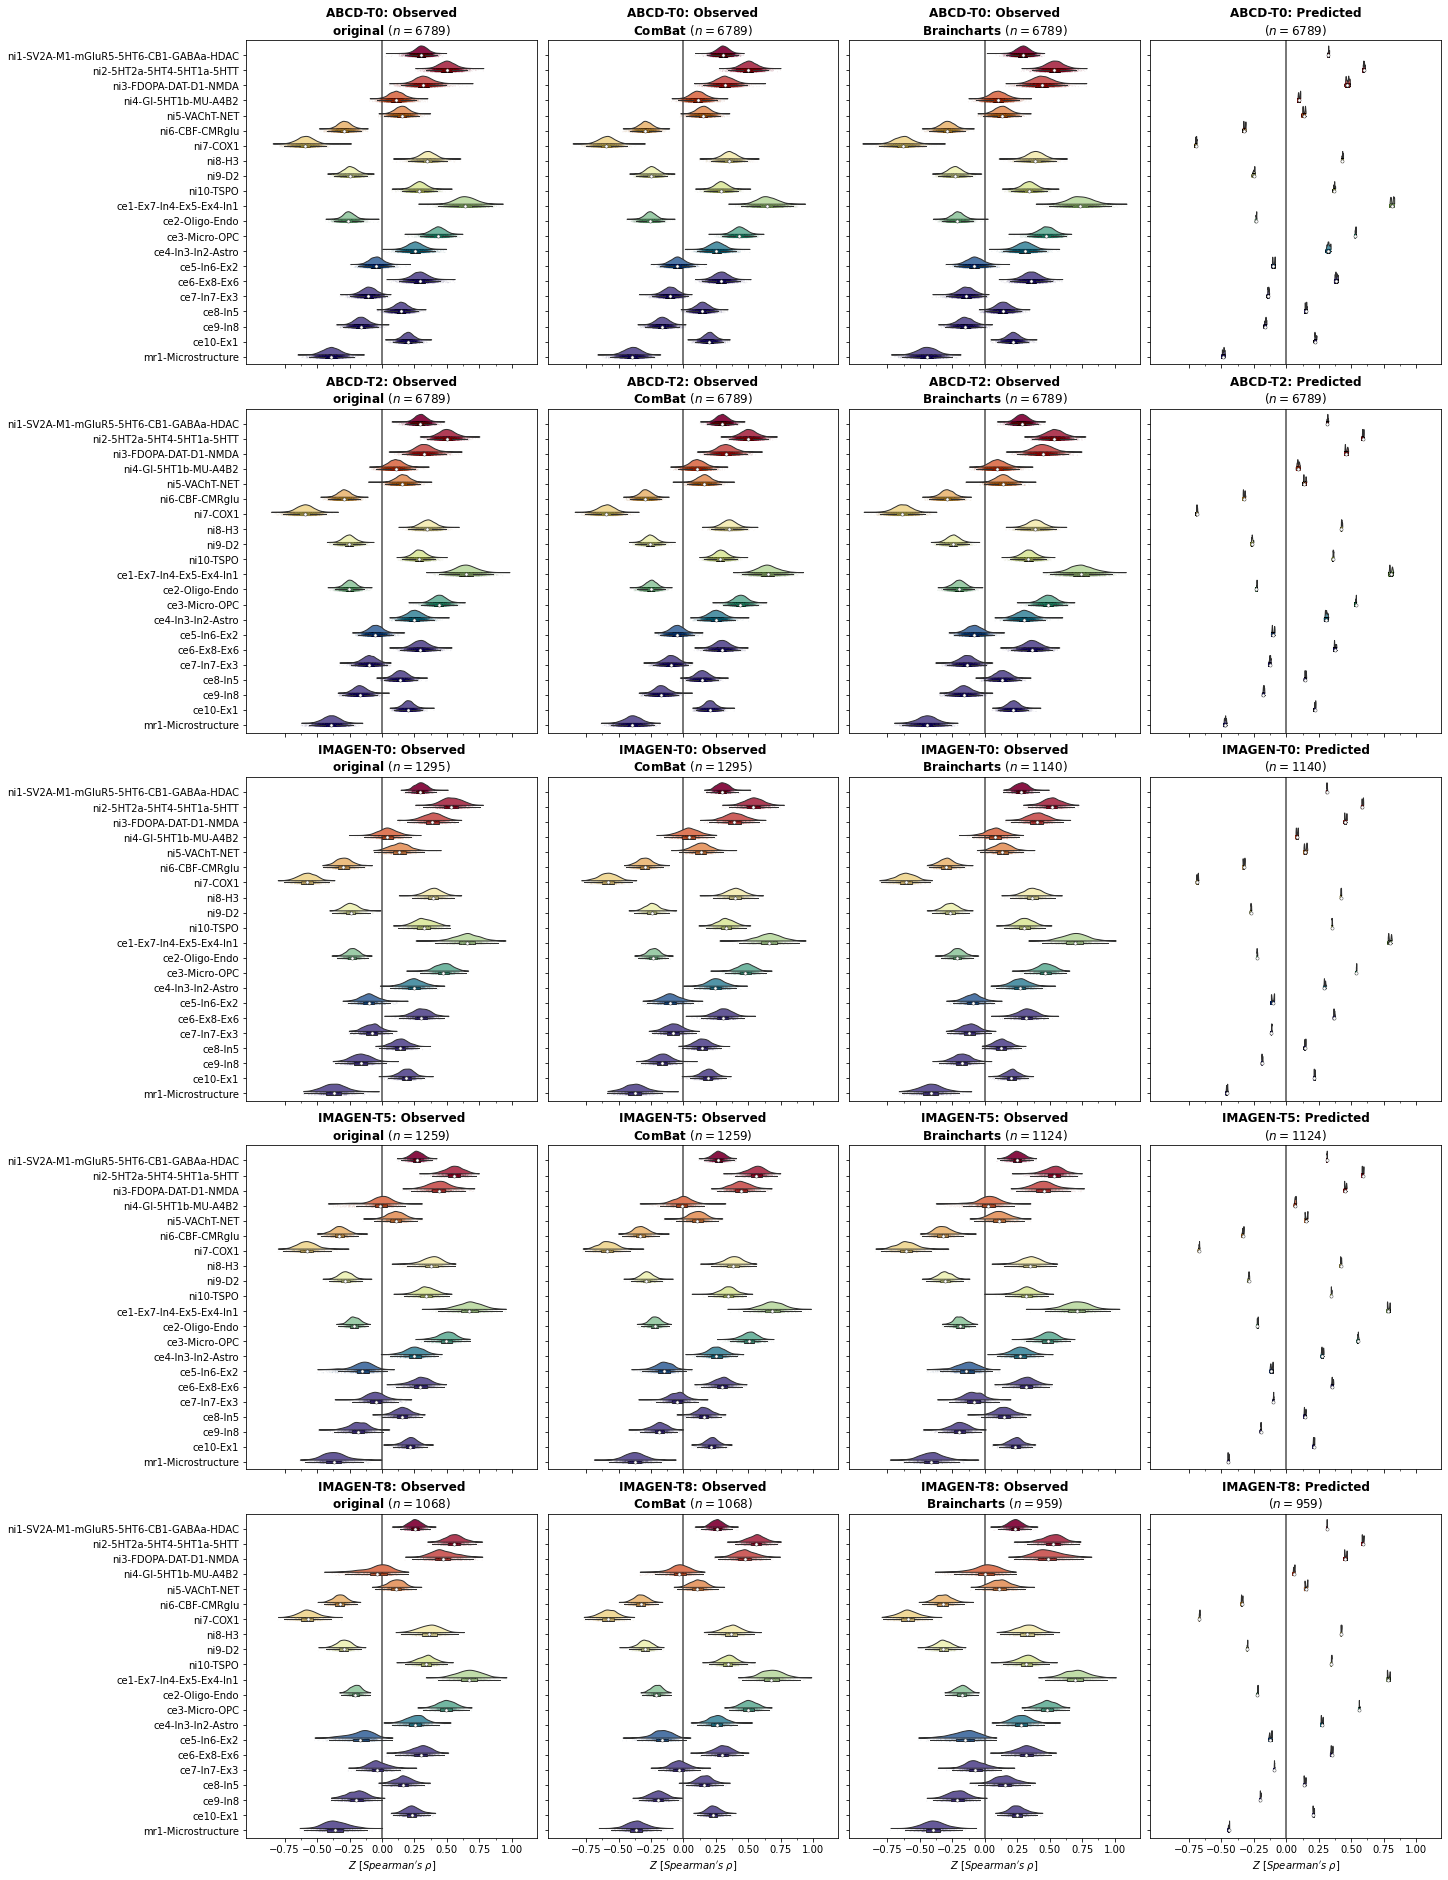

In [24]:
colors = get_cmap("Spectral")(np.arange(0,len(predictors)) * int(365/len(predictors)))

# source data
source_data = {}

fig, axes = plt.subplots(n_tp, 4, figsize=(20,26), sharey=True, sharex=True, constrained_layout=True)

# iterate analyses
for c, (analysis, title) in enumerate(zip(
    ["orig", "harm", "rescaled", "pred"],
    ["Observed\noriginal ", "Observed\nComBat ", "Observed\nBraincharts ", "Predicted\n"])):
    
    for r, ds_tp in enumerate(ds_tps):
        ds = ds_tp[0]
        tp = ds_tp[1]
        
        # predicted
        plot_raincloud(
            data=res_cross.loc[(ds, na(), tp, analysis)].melt(),
            x="value",
            y="variable",
            x_mean=res_cross.loc[(ds, na(), tp, analysis)].mean(),
            y_mean=range(len(predictors)),
            ax=axes[r,c],
            title="",
            xlab="",
            colors=colors
        )
        axes[r,c].axvline(0, c="0.3", zorder=0)

        axes[r,c].set_title(f"{'ABCD' if ds=='abcd' else 'IMAGEN'}-{tp}: {title}"
                            f"$(n={res_cross.loc[(ds, na(), tp, analysis)].shape[0]})$",
                            weight="semibold")
        axes[r,c].set_ylim((len(predictors)-0.5, -1))
        axes[r,c].set_yticklabels(rename_myelin(predictors))
        axes[r,c].set_xticks(np.arange(-0.75, 1.1, 0.25))
        axes[r,c].set_xticks(np.arange(-0.75, 1.1, 0.125), minor=True)
    
        if r==n_tp-1:
            axes[r,c].set_xlabel(r"$Z\ [Spearman's\ \rho$]")
            
        # source data
        source_data[ds, tp, analysis] = res_cross.loc[(ds, na(), tp, analysis)].describe().T
            
fig.savefig(join(plot_dir, "dev_ct_spearman.png"), bbox_inches="tight", dpi=300)
pd.concat(source_data).to_csv(join(plot_dir, "dev_ct_spearman_source.csv"))

## Results: Longitudinal: prediction

### Can the Braincharts model predict regional CT change?  

In [25]:
cor = np.zeros((4, len(destrieux_idps)))

for i, ds_ts in enumerate(ds_tss):
    
    temp = data_delta.loc[(ds_ts[0], na(), ds_ts[1]), :].dropna()
    for ii, idp in enumerate(destrieux_idps): 
        cor[i, ii] = corr(
            temp[idp+"-delta_resc"], 
            temp[idp+"-delta_pred"], 
            rank=True
        )
        
cor = pd.DataFrame(
    cor, 
    index=pd.MultiIndex.from_tuples(ds_tss), 
    columns=[i.replace("_thickness", "") for i in destrieux_idps]
)
cor.to_csv(join(abcdimgn_dir, "corr_delta_pred_obs.csv"))

print("Mean correlation per cohort:\n", cor.mean(1))
print("Max correlation per cohort:\n", cor.max(1))

cor

Mean correlation per cohort:
 abcd  T0T2    0.050610
imgn  T0T8    0.090118
      T0T5    0.164371
      T5T8    0.079609
dtype: float64
Max correlation per cohort:
 abcd  T0T2    0.114990
imgn  T0T8    0.287844
      T0T5    0.412168
      T5T8    0.193790
dtype: float64


lh_G&S_frontomargin  lh_G&S_occipital_inf  lh_G&S_paracentral  \
abcd T0T2             0.044084              0.065808            0.038086   
imgn T0T8             0.174837              0.189803            0.108591   
     T0T5             0.273603              0.222515            0.165313   
     T5T8             0.061631              0.122954            0.079672   

           lh_G&S_subcentral  lh_G&S_transv_frontopol  lh_G&S_cingul-Ant  \
abcd T0T2           0.052946                 0.041062           0.066776   
imgn T0T8           0.144419                 0.150465           0.020573   
     T0T5           0.288125                 0.282863           0.182594   
     T5T8           0.122027                 0.137170           0.129221   

           lh_G&S_cingul-Mid-Ant  lh_G&S_cingul-Mid-Post  \
abcd T0T2               0.061511                0.065783   
imgn T0T8               0.022264               -0.035253   
     T0T5               0.236672                0.137748   
     T5T8               0.062629                0.067057   

           lh_G_cingul-Post-dorsal  lh_G_cingul-Post-ventral  ...  \
abcd T0T2                 0.036237                  0.050080  ...   
imgn T0T8                -0.037752                  0.035817  ...   
     T0T5                 0.048399                  0.014041  ...   
     T5T8                 0.065121                  0.012471  ...   

           rh_S_parieto_occipital  rh_S_pericallosal  rh_S_postcentral  \
abcd T0T2                0.111558           0.025519          0.082045   
imgn T0T8                0.166724          -0.022088          0.114434   
     T0T5                0.200149           0.022883          0.173463   
     T5T8                0.132291          -0.011003          0.044109   

           rh_S_precentral-inf-part  rh_S_precentral-sup-part  \
abcd T0T2                  0.062616                  0.041662   
imgn T0T8                  0.092044                  0.131231   
     T0T5                  0.215004                  0.242446   
     T5T8                  0.045689                  0.090811   

           rh_S_suborbital  rh_S_subparietal  rh_S_temporal_inf  \
abcd T0T2         0.045604          0.038950           0.042444   
imgn T0T8         0.076512          0.096458          -0.127309   
     T0T5         0.154502          0.185303          -0.101770   
     T5T8         0.069967          0.017676           0.096768   

           rh_S_temporal_sup  rh_S_temporal_transverse  
abcd T0T2           0.101539                  0.021765  
imgn T0T8          -0.045332                 -0.053765  
     T0T5           0.031357                 -0.001324  
     T5T8           0.077251                  0.009253  

[4 rows x 148 columns]

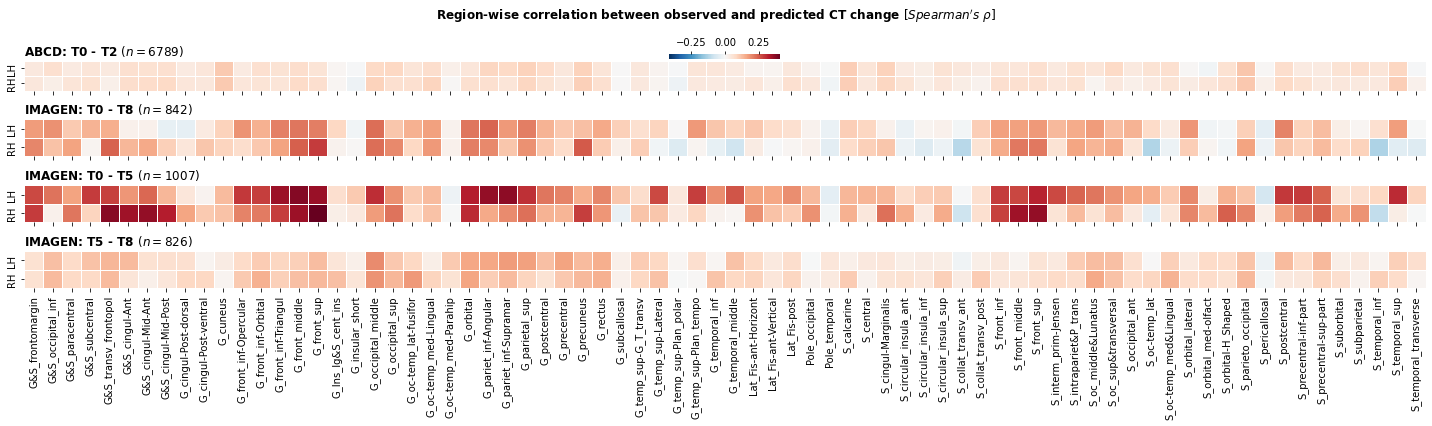

In [26]:
fig, axes = plt.subplots(cor.shape[0],1, figsize=(20,6), sharex=True)

lim = cor.abs().max().max()

for r, ds_ts in enumerate(ds_tss):
    
    sns.heatmap(
        np.vstack([cor.iloc[r,:74], cor.iloc[r,74:]]), 
        linewidths=1,
        cmap="RdBu_r",
        center=0,
        vmin=-lim,
        vmax=lim,
        ax=axes[r],
        cbar=True if r==0 else False,
        cbar_kws=dict(location="top")
    )
    
    axes[r].set_xticklabels([c.replace("lh_","") for c in cor.iloc[:1,:74].columns], rotation=90)
    axes[r].set_yticklabels(["LH", "RH"], va="center")
    axes[r].set_title(f"{'ABCD' if ds_ts[0]=='abcd' else 'IMAGEN'}: {ds_ts[1][:2]} - {ds_ts[1][2:]}"
                      f" $(n = {data_delta.loc[(ds_ts[0], na(), ds_ts[1]), :].dropna().shape[0]})$", 
                      loc="left", weight="semibold")
    
fig.suptitle("Region-wise correlation between observed and predicted CT change " + r"$[Spearman's\ \rho]$", weight="semibold")
fig.tight_layout()
plt.savefig(join(plot_dir, f"dev_delta_correlation.pdf"), bbox_inches="tight")
cor.to_csv(join(plot_dir, "dev_delta_correlation_source.csv"))

### Can we predict single-subject CT change from multimodal predictors? 

In [27]:
print("CT-change [%]: Cohort average, ComBat-harmonized")
display(res_delta_allmean.round(3))
display(sig_delta_allmean)
print("CT-change [%]: Site average, ComBat-harmonized")
display(res_delta_sitemean.groupby("ts").mean().round(3))
display(sig_delta_sitemean)
print("CT-change [%]: Single-subject average, ComBat-harmonized")
print("mean")
display(res_delta.loc[(na(), na(), na(), "delta")].groupby("ts").mean().round(3))
display(sig_delta)
print("max")
display(res_delta.loc[(na(), na(), na(), "delta")].groupby("ts").max().round(3))
print("min")
display(res_delta.loc[(na(), na(), na(), "delta")].groupby("ts").min().round(3))


CT-change [%]: Cohort average, ComBat-harmonized


full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  \
ds   ts                                                            
abcd T0T2    0.430                 0.003           0.021   0.122   
imgn T0T8    0.514                 0.182           0.031   0.121   
     T0T5    0.574                 0.131           0.045   0.150   
     T5T8    0.273                 0.163           0.016   0.029   

           ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  \
ds   ts                                                             
abcd T0T2          0.207              0.010        0.020    0.046   
imgn T0T8          0.035              0.008        0.126    0.010   
     T0T5          0.077              0.004        0.157    0.009   
     T5T8         -0.001              0.015        0.048    0.003   

           spearman_ni4-GI-5HT1b-MU-A4B2  spearman_ni6-CBF-CMRglu  \
ds   ts                                                             
abcd T0T2                         -0.126                   -0.258   
imgn T0T8                         -0.671                   -0.269   
     T0T5                         -0.634                   -0.334   
     T5T8                         -0.532                   -0.100   

           spearman_ni9-D2  spearman_ce3-Micro-OPC  \
ds   ts                                              
abcd T0T2           -0.524                   0.530   
imgn T0T8           -0.446                   0.254   
     T0T5           -0.476                   0.352   
     T5T8           -0.238                   0.115   

           spearman_ce4-In3-In2-Astro  spearman_ce5-In6-Ex2  spearman_ce9-In8  
ds   ts                                                                        
abcd T0T2                       0.038                -0.168            -0.258  
imgn T0T8                       0.135                -0.519            -0.239  
     T0T5                       0.101                -0.557            -0.216  
     T5T8                       0.146                -0.342            -0.166

full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  \
ds   ts                                                            
abcd T0T2    0.001                 0.701           0.372   0.014   
imgn T0T8    0.001                 0.011           0.333   0.048   
     T0T5    0.001                 0.078           0.306   0.057   
     T5T8    0.001                 0.001           0.284   0.184   

           ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  
ds   ts                                                            
abcd T0T2          0.001              0.363        0.351    0.040  
imgn T0T8          0.287              0.517        0.021    0.455  
     T0T5          0.147              0.661        0.023    0.535  
     T5T8          0.683              0.242        0.053    0.511

CT-change [%]: Site average, ComBat-harmonized


full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  ce3-Micro-OPC  \
ts                                                                           
T0T2    0.330                 0.008           0.016   0.083          0.138   
T0T5    0.400                 0.077           0.028   0.111          0.062   
T0T8    0.324                 0.090           0.020   0.074          0.030   
T5T8    0.208                 0.053           0.018   0.045          0.021   

      ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  spearman_ni4-GI-5HT1b-MU-A4B2  \
ts                                                                             
T0T2              0.017        0.019    0.048                         -0.103   
T0T5              0.010        0.087    0.024                         -0.392   
T0T8              0.014        0.082    0.014                         -0.417   
T5T8              0.026        0.044    0.002                         -0.226   

      spearman_ni6-CBF-CMRglu  spearman_ni9-D2  spearman_ce3-Micro-OPC  \
ts                                                                       
T0T2                   -0.207           -0.403                   0.409   
T0T5                   -0.263           -0.380                   0.283   
T0T8                   -0.187           -0.339                   0.164   
T5T8                   -0.002           -0.162                  -0.037   

      spearman_ce4-In3-In2-Astro  spearman_ce5-In6-Ex2  spearman_ce9-In8  
ts                                                                        
T0T2                       0.044                -0.123            -0.213  
T0T5                       0.083                -0.351            -0.166  
T0T8                       0.069                -0.336            -0.155  
T5T8                      -0.048                -0.154            -0.067

full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  \
ds   ts                                                            
abcd T0T2    0.001                 0.727           0.455   0.017   
imgn T0T8    0.001                 0.025           0.504   0.054   
     T0T5    0.001                 0.083           0.375   0.018   
     T5T8    0.001                 0.055           0.495   0.093   

           ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  
ds   ts                                                            
abcd T0T2          0.001              0.227        0.355    0.013  
imgn T0T8          0.313              0.439        0.012    0.388  
     T0T5          0.082              0.621        0.023    0.196  
     T5T8          0.331              0.100        0.047    0.843

CT-change [%]: Single-subject average, ComBat-harmonized
mean


full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  ce3-Micro-OPC  \
ts                                                                           
T0T2    0.092                 0.011           0.007   0.015          0.026   
T0T5    0.164                 0.039           0.013   0.025          0.025   
T0T8    0.182                 0.052           0.013   0.028          0.021   
T5T8    0.131                 0.038           0.010   0.015          0.019   

      ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  spearman_ni4-GI-5HT1b-MU-A4B2  \
ts                                                                             
T0T2              0.011        0.013    0.009                         -0.012   
T0T5              0.014        0.035    0.013                         -0.182   
T0T8              0.015        0.040    0.012                         -0.230   
T5T8              0.017        0.021    0.011                         -0.087   

      spearman_ni6-CBF-CMRglu  spearman_ni9-D2  spearman_ce3-Micro-OPC  \
ts                                                                       
T0T2                   -0.038           -0.075                   0.075   
T0T5                   -0.121           -0.147                   0.113   
T0T8                   -0.098           -0.160                   0.081   
T5T8                   -0.009           -0.047                  -0.004   

      spearman_ce4-In3-In2-Astro  spearman_ce5-In6-Ex2  spearman_ce9-In8  
ts                                                                        
T0T2                       0.009                -0.015            -0.048  
T0T5                       0.041                -0.168            -0.069  
T0T8                       0.042                -0.184            -0.089  
T5T8                       0.006                -0.057            -0.031

full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  \
ds   ts                                                            
abcd T0T2    0.001                 0.170           0.307   0.040   
imgn T0T8    0.001                 0.013           0.499   0.153   
     T0T5    0.001                 0.038           0.481   0.172   
     T5T8    0.001                 0.001           0.466   0.285   

           ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  
ds   ts                                                            
abcd T0T2          0.001              0.022        0.045    0.042  
imgn T0T8          0.221              0.202        0.014    0.201  
     T0T5          0.105              0.209        0.020    0.149  
     T5T8          0.105              0.032        0.052    0.110

max


full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  ce3-Micro-OPC  \
ts                                                                           
T0T2    0.413                 0.184           0.173   0.223          0.297   
T0T5    0.547                 0.305           0.105   0.259          0.205   
T0T8    0.577                 0.328           0.149   0.231          0.236   
T5T8    0.610                 0.393           0.112   0.145          0.216   

      ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  spearman_ni4-GI-5HT1b-MU-A4B2  \
ts                                                                             
T0T2              0.174        0.182    0.193                          0.558   
T0T5              0.216        0.240    0.148                          0.490   
T0T8              0.176        0.213    0.138                          0.491   
T5T8              0.161        0.171    0.129                          0.629   

      spearman_ni6-CBF-CMRglu  spearman_ni9-D2  spearman_ce3-Micro-OPC  \
ts                                                                       
T0T2                    0.566            0.413                   0.642   
T0T5                    0.407            0.380                   0.624   
T0T8                    0.428            0.305                   0.644   
T5T8                    0.620            0.575                   0.548   

      spearman_ce4-In3-In2-Astro  spearman_ce5-In6-Ex2  spearman_ce9-In8  
ts                                                                        
T0T2                       0.497                 0.500             0.366  
T0T5                       0.607                 0.500             0.368  
T0T8                       0.538                 0.441             0.468  
T5T8                       0.474                 0.474             0.338

min


full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  ce3-Micro-OPC  \
ts                                                                           
T0T2   -0.046                -0.007          -0.007  -0.007         -0.007   
T0T5   -0.026                -0.007          -0.006  -0.007         -0.007   
T0T8   -0.035                -0.007          -0.007  -0.007         -0.007   
T5T8   -0.034                -0.007          -0.007  -0.007         -0.007   

      ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  spearman_ni4-GI-5HT1b-MU-A4B2  \
ts                                                                             
T0T2             -0.007       -0.007   -0.007                         -0.583   
T0T5             -0.007       -0.006   -0.007                         -0.853   
T0T8             -0.007       -0.007   -0.007                         -0.974   
T5T8             -0.007       -0.006   -0.007                         -0.903   

      spearman_ni6-CBF-CMRglu  spearman_ni9-D2  spearman_ce3-Micro-OPC  \
ts                                                                       
T0T2                   -0.551           -0.546                  -0.493   
T0T5                   -0.592           -0.625                  -0.456   
T0T8                   -0.578           -0.617                  -0.478   
T5T8                   -0.441           -0.535                  -0.543   

      spearman_ce4-In3-In2-Astro  spearman_ce5-In6-Ex2  spearman_ce9-In8  
ts                                                                        
T0T2                      -0.470                -0.644            -0.486  
T0T5                      -0.427                -0.746            -0.452  
T0T8                      -0.412                -0.705            -0.468  
T5T8                      -0.505                -0.567            -0.352

#### Main results plot

##### Combined prediction performance

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/1859710993.py:95: RuntimeWarning: Mean of empty slice
  "predicted_ct_change": y_ if r<2 else np.nanmean(y_, 0),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/1859710993.py:96: RuntimeWarning: Mean of empty slice
  "residual_difference": pe if r<2 else np.nanmean(pe, 0)
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/1859710993.py:95: RuntimeWarning: Mean of empty slice
  "predicted_ct_change": y_ if r<2 else np.nanmean(y_, 0),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/1859710993.py:96: RuntimeWarning: Mean of empty slice
  "residual_difference": pe if r<2 else np.nanmean(pe, 0)
Context leak detected, msgtracer returned -1
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/1859710993.py:95: RuntimeWarning: Mean of empty slice
  "predicted_ct_change": y_ if r<2 else np.nanmean(y_, 0),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_6692/18597109

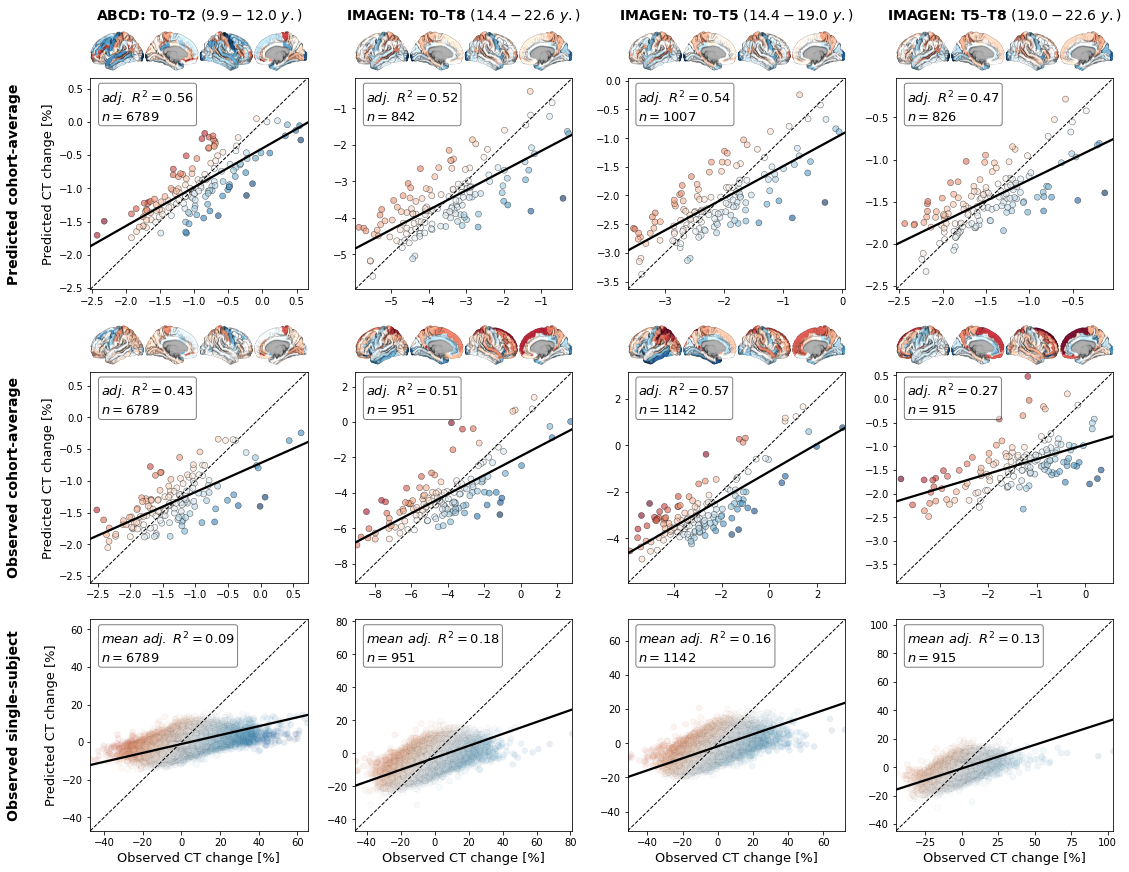

In [33]:
# MLR stats
def mlr(x, y):    
    X = np.c_[x, np.ones(x.shape[0])] 
    beta = np.linalg.pinv((X.T).dot(X)).dot(X.T.dot(y))
    y_hat = np.dot(X, beta)
    pe = y_hat - y
    ss_res = np.sum((y-y_hat)**2)       
    ss_tot = np.sum((y-np.mean(y))**2)   
    r2 = 1 - ss_res / ss_tot  
    r2 = 1 - (1-r2) * (len(y)-1) / (len(y)-x.shape[1]-1)
    return y_hat, pe, r2

# predictor data
x = predictors_destrieux[predictors_both].values
nonan = ~np.isnan(x).any(1)

# source data
source_data = {}
 
# estimate and plot
fig, axes = plt.subplots(3, len(ds_tss), figsize=(15.5,12), constrained_layout=True,
                         gridspec_kw=dict(hspace=0.06, wspace=0.07))

for c, (ds, ts) in enumerate(ds_tss):
    
    for r, (df, n) in enumerate([
        (data_delta_long.loc[(ds, na(), ts, "delta_pred")].mean(), data_delta_long.loc[(ds, na(), ts, "delta_pred")].shape[0]),
        (data_delta_long_allmean.loc[(ds,ts)], data_delta_long.loc[(ds, na(), ts, "delta")].shape[0]),
        (data_delta_long.loc[(ds, na(), ts, "delta")], data_delta_long.loc[(ds, na(), ts, "delta")].shape[0])
    ]):
        
        y = df.values * 100
        y_, pe = y.copy(), y.copy()
        y_[:], pe[:] = np.nan, np.nan
        
        if r<2:
            y_[nonan], pe[nonan], r2 = mlr(x=x[nonan,:], y=y[nonan])
        elif r==2:
            r2 = np.zeros(df.shape[0])
            for i in range(df.shape[0]): 
                y_[i,nonan], pe[i,nonan], r2[i] = mlr(x=x[nonan,:], y=y[i,nonan]) 
            r2 = np.mean(r2)
        
        lim = (np.nanmin([np.nanmin(y_), np.nanmin(y)]) - 0.1, 
               np.nanmax([np.nanmax(y_), np.nanmax(y)]) + 0.1)
        pe_lim = np.nanmax(np.abs(pe))
        
        if r<2:
            ax = axes[r,c].inset_axes((0, 1, 1, 0.25))
            lh, rh = get_parc_gifti(pe if r<2 else np.nanmean(pe, 0), parc_destrieux)
            plot_surf_ax(ax=ax, fig=fig, lh=lh, rh=rh, c="RdBu_r", c_lims=(-pe_lim, pe_lim))
            ax.set_axis_off()

        axes[r,c].scatter(
            x=y, 
            y=y_, 
            c=pe, 
            vmin=-pe_lim,
            vmax=pe_lim,
            cmap="RdBu_r",
            ec="k",
            lw=0.5 if r<2 else 0.2,
            alpha=0.6 if r<2 else 0.1
        )
        axes[r,c].plot([lim[0], lim[1]], [lim[0], lim[1]], c="k", lw=1, ls="--")
        sns.regplot(x=y.flatten(), y=y_.flatten(), scatter=False, ci=None, ax=axes[r,c], truncate=False, color="k")

        axes[r,c].annotate(
            f"${'mean ' if r==2 else ''}adj. R^2={r2:.02f}$\n$n={n}$".replace(" ", "\ "),
            xy=(0.05,0.95),
            va="top",
            ha="left",
            size=13,
            xycoords="axes fraction",
            bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.5)
        )
        
        axes[r,c].set_xlim(lim)
        axes[r,c].set_ylim(lim)
        
        if r==0:
            axes[r,c].set_title(f"{'ABCD' if ds=='abcd' else 'IMAGEN'}: {ts[:2]}–{ts[2:]} "
                                f"$({tss_age_exact[c][0]:.01f}-{tss_age_exact[c][1]:.01f}\ y.)$", 
                                weight="semibold", size=14, pad=10)
        if c==0:
            axes[r,c].set_ylabel("Predicted CT change [%]", size=13)
        if r==2:
            axes[r,c].set_xlabel("Observed CT change [%]", size=13)
            
        # source
        k = "predicted_cohort" if r==0 else "observed_cohort" if r==1 else "observed_single_subject"
        source_data[ds, ts, k] = pd.DataFrame(
            {
                "observed_ct_change": y if r<2 else np.nanmean(y, 0),
                "predicted_ct_change": y_ if r<2 else np.nanmean(y_, 0),
                "residual_difference": pe if r<2 else np.nanmean(pe, 0)
            },
            index=predictors_destrieux.index
        )
            
[axes[r,0].annotate(title, xy=(-0.35,0.5), xycoords="axes fraction", 
                    ha="center", va="center", rotation=90, weight="semibold", size=14) 
 for r, title 
 in enumerate(["Predicted cohort-average", "Observed cohort-average", "Observed single-subject"])]

plt.savefig(join(plot_dir, f"dev_delta_main_overall.png"), bbox_inches="tight", dpi=600)

pd.concat(source_data, names=["dataset", "timespan", "analysis", "region"]) \
    .to_csv(join(plot_dir, "dev_delta_main_overall_source.csv"))

##### Predictor-level comparison

INFO: Loaded complete object from /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_dominance_fm_500_5.pkl.gz.


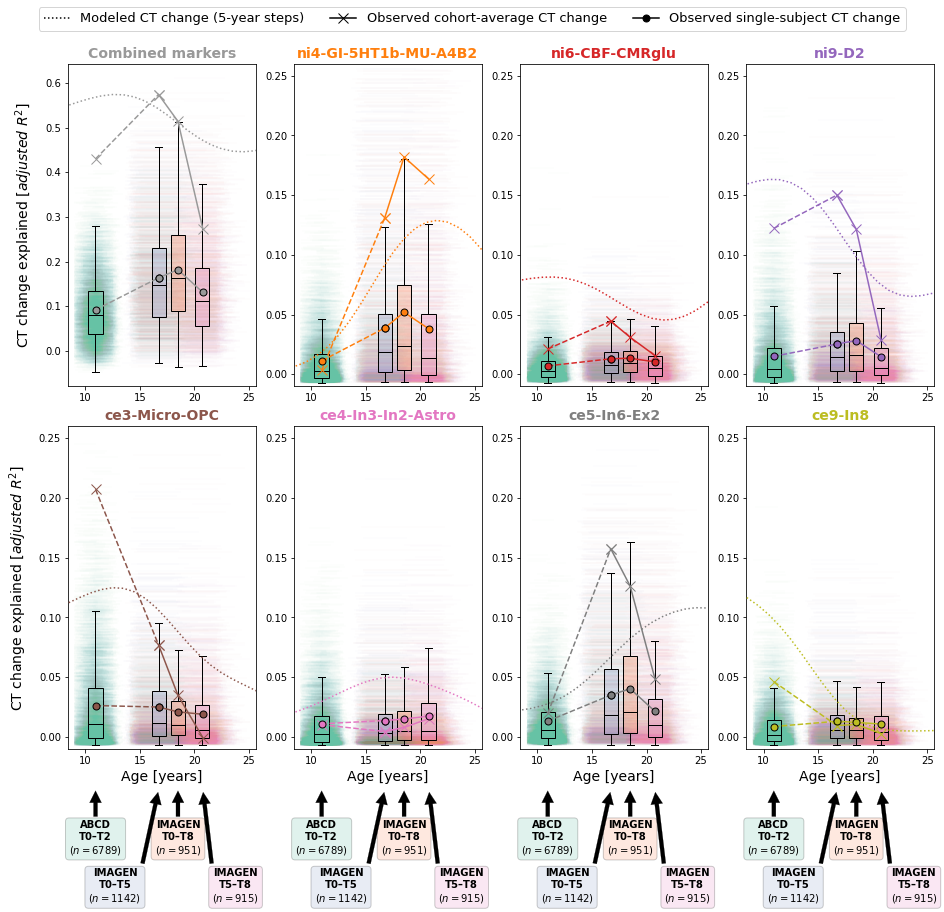

In [31]:
juspyce_ct_dominance = JuSpyce.from_pickle(join(wd, "data_rutherford", "juspyce_ct_dominance_fm_500_5.pkl.gz"))

# source data
source_data = {}

fig, axes = plt.subplots(3,4, figsize=(13,12), constrained_layout=True,
                         gridspec_kw=dict(height_ratios=[1,1,0.3]))
axes = axes.ravel()

# color sets
pred_colors = np.row_stack([np.array([0.6,0.6,0.6,1]), c_predictors_both])
cohort_colors = sns.color_palette("Set2", 4)

# iterate predictors
for i, pred in enumerate(["full_r2"] + predictors_both):
    
    # iterate datasets
    for (ds, ts), color in zip(ds_tss, cohort_colors):
        
        # subjects and subject age
        subs = res_delta.loc[ds,na(),ts,"delta"].index.get_level_values("id").to_list()
        subs_age1 = data_cross.loc[ds,subs,ts[:2]].age.values
        subs_age2 = data_cross.loc[ds,subs,ts[2:]].age.values        

        # datasets
        data = res_delta.loc[(ds,subs,ts,"delta"), pred]
        if pred=="full_r2":
            data_model = juspyce_ct_dominance.predictions["dominance_full_r2"].iloc[1:,0]
        else:
            data_model = juspyce_ct_dominance.predictions["dominance_total"][pred][1:]
        data_model.index = np.arange(5,86,1) + 2.5
        
        # horizontal line for each subject, across each subject's exact investigated time span
        axes[i].hlines(
            xmin=subs_age1, 
            xmax=subs_age2,
            y=data,
            alpha=0.015,
            color=color
        )
        
        # boxplot for each cohort's mean
        axes[i].boxplot(
            x=data,
            positions=[( (subs_age1 + subs_age2)/2 ).mean()],
            showfliers=False,
            widths=1.3,
            patch_artist=True,
            boxprops=dict(facecolor=color + (0.3,)),
            medianprops=dict(c="k"),
            manage_ticks=False,
            zorder=90
        )
        
        # source
        source_data[pred, "observed_single_subject", ds, ts] = data.describe().iloc[1:]
        source_data[pred, "observed_cohort", ds, ts] = \
            pd.Series(res_delta_allmean[pred].loc[ds, ts], index=["mean"])
        
    # Modeled CT change over 5-year steps as shown in the first analyses for comparison
    axes[i].plot(
        data_model.index,
        data_model,
        c=pred_colors[i],
        linestyle=":",
        label="Modeled CT change (5-year steps)",
        zorder=100
    )
    # source
    for age in data_model.index:
        source_data[pred, "observed_predicted", "braincharts", age] = \
            pd.Series(data_model[age], index=["mean"])

    # connect time spans and plot mean points for each time span
    # two connection line styles, because ABCD -> IMAGEN shown differently
    for idc, linestyle in zip([[0,2], [2,1,3]], ["--", "-"]):
        
        # Cohort average
        axes[i].plot(
            np.array(tss_age_mean)[idc],
            res_delta_allmean[pred][idc],
            c=pred_colors[i],
            marker="x",
            markersize=10,
            linestyle=linestyle,
            label="Observed cohort-average CT change" if linestyle=="-" else None,
            zorder=100
        )
        
        # Single subject average
        axes[i].plot(
            np.array(tss_age_mean)[idc],
            res_delta.loc[(na(),na(),na(),"delta"), pred].groupby("ts").mean()[tss][idc],
            c=pred_colors[i],
            marker="o",
            markeredgecolor="k",
            markersize=7,
            linestyle=linestyle,
            label="Observed single-subject CT change" if linestyle=="-" else None,
            zorder=100
        )

    # general
    axes[i].set_title(pred if pred!="full_r2" else "Combined markers", color=pred_colors[i], 
                      size=14, weight="semibold")
    axes[i].set_xlim(data_cross.age.min()-0.5, data_cross.age.max()+0.5)
    if i>0:
        axes[i].set_ylim(-0.01, 0.26)
        
axes = axes.reshape((3,4)) 
[axes[r,0].set_ylabel("CT change explained [$adjusted\ R^2$]", size=14, labelpad=10) for r in range(2)]
[axes[1,c].set_xlabel("Age [years]", size=14) for c in range(4)]
        
# Cohort/time span annotations at the bottom of the plot
for i, (ds, ts) in enumerate(ds_tss):
    for c in range(4):
        ytext = [0.5, 0.5, 0, 0]
        xtext = tss_age_mean[i] + np.array([0, 0, -4, 3])
        t = axes[2,c].annotate(
            f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n"
            f"{ts[:2]}–{ts[2:]}\n"
            f"$(n={res_delta.loc[(ds, na(), ts, 'delta'),].shape[0]})$",
            xy=(tss_age_mean[i], 1),
            xytext=(xtext[i], ytext[i]),
            weight="semibold",
            ha="center",
            va="center",
            zorder=100,
            arrowprops=dict(facecolor='k', shrink=0.03, lw=0.2, zorder=90),
            bbox=dict(boxstyle="round,pad=0.35", fc=cohort_colors[i], alpha=0.2, zorder=100)
        )
        axes[2,c].set_axis_off()
        axes[2,c].set_ylim(0,1)
        axes[2,c].set_xlim(data_cross.age.min()-0.5, data_cross.age.max()+0.5)  

# legend
handles, labels = axes[0,0].get_legend_handles_labels()
handles = [copy.copy(h) for h in handles]
[h.set_color("k") for h in handles]
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5,1.05), ncol=3, labelcolor="k",
           fontsize=13)

# source
source_data = pd.DataFrame(source_data).T
source_data.index.names = ["marker", "analysis", "dataset", "timespan/age"]
source_data = source_data[["mean", "std", "min", "25%", "50%", "75%", "max"]]

# save
plt.savefig(join(plot_dir, f"dev_delta_main_predictors.png"), bbox_inches="tight", dpi=600)
source_data.to_csv(join(plot_dir, "dev_delta_main_predictors_source.csv"))

#### Full R2 distributions

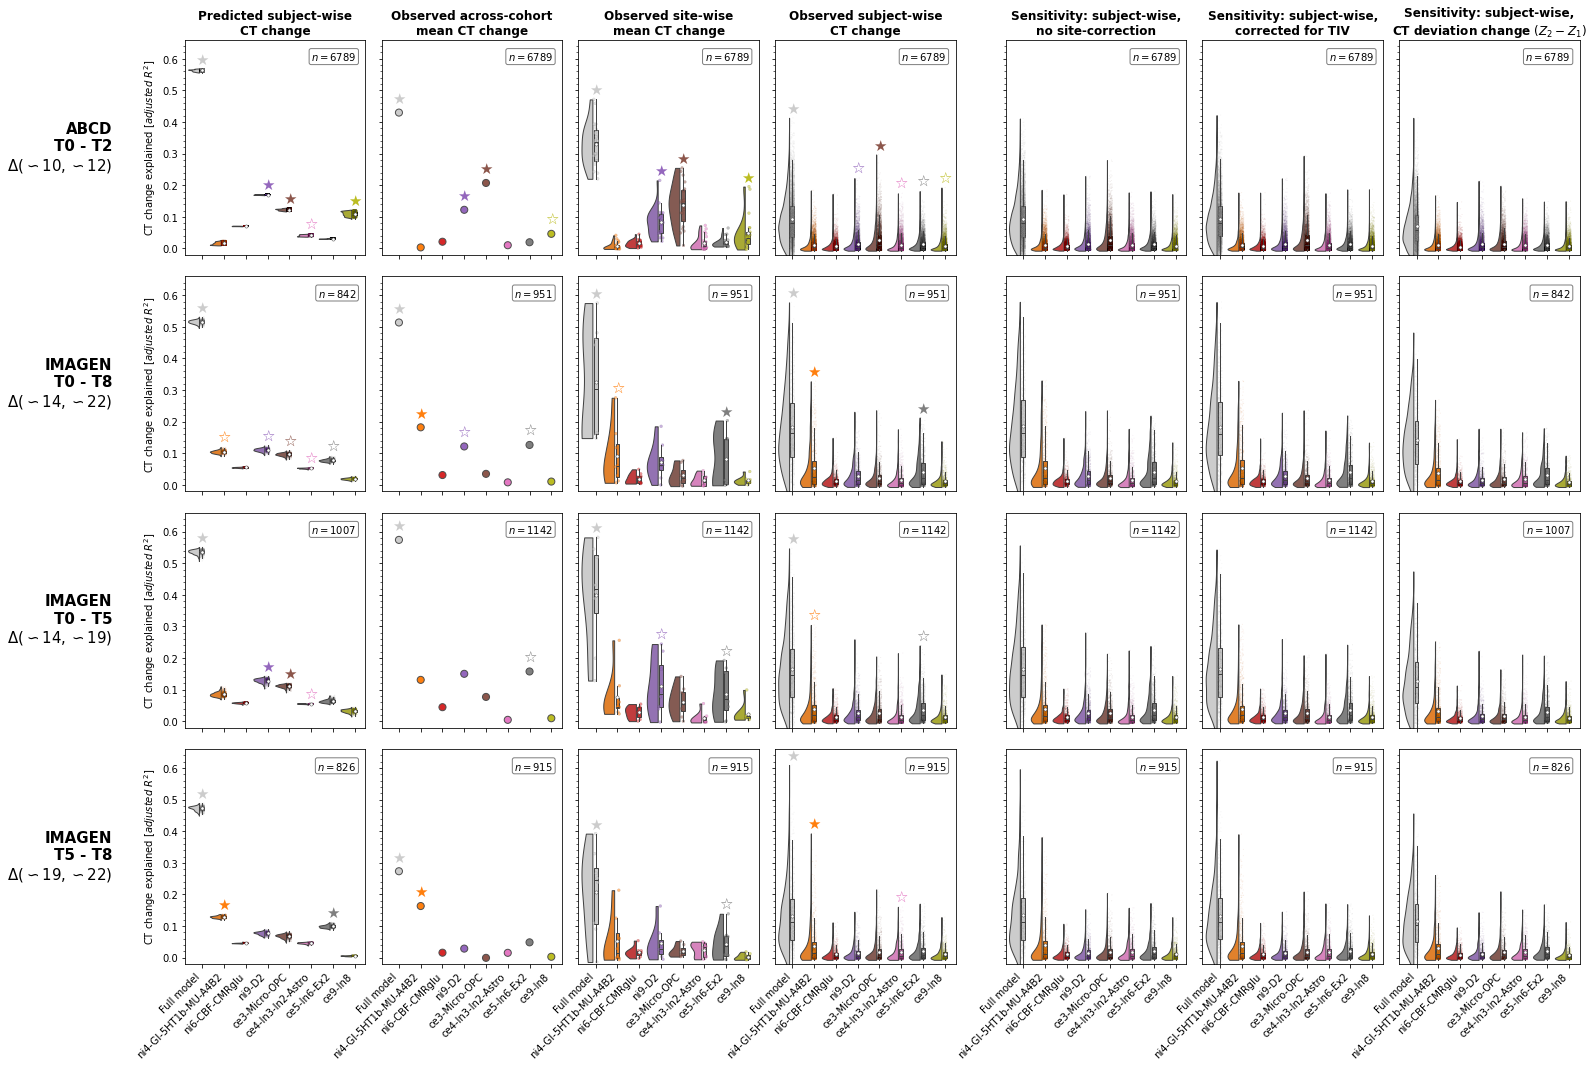

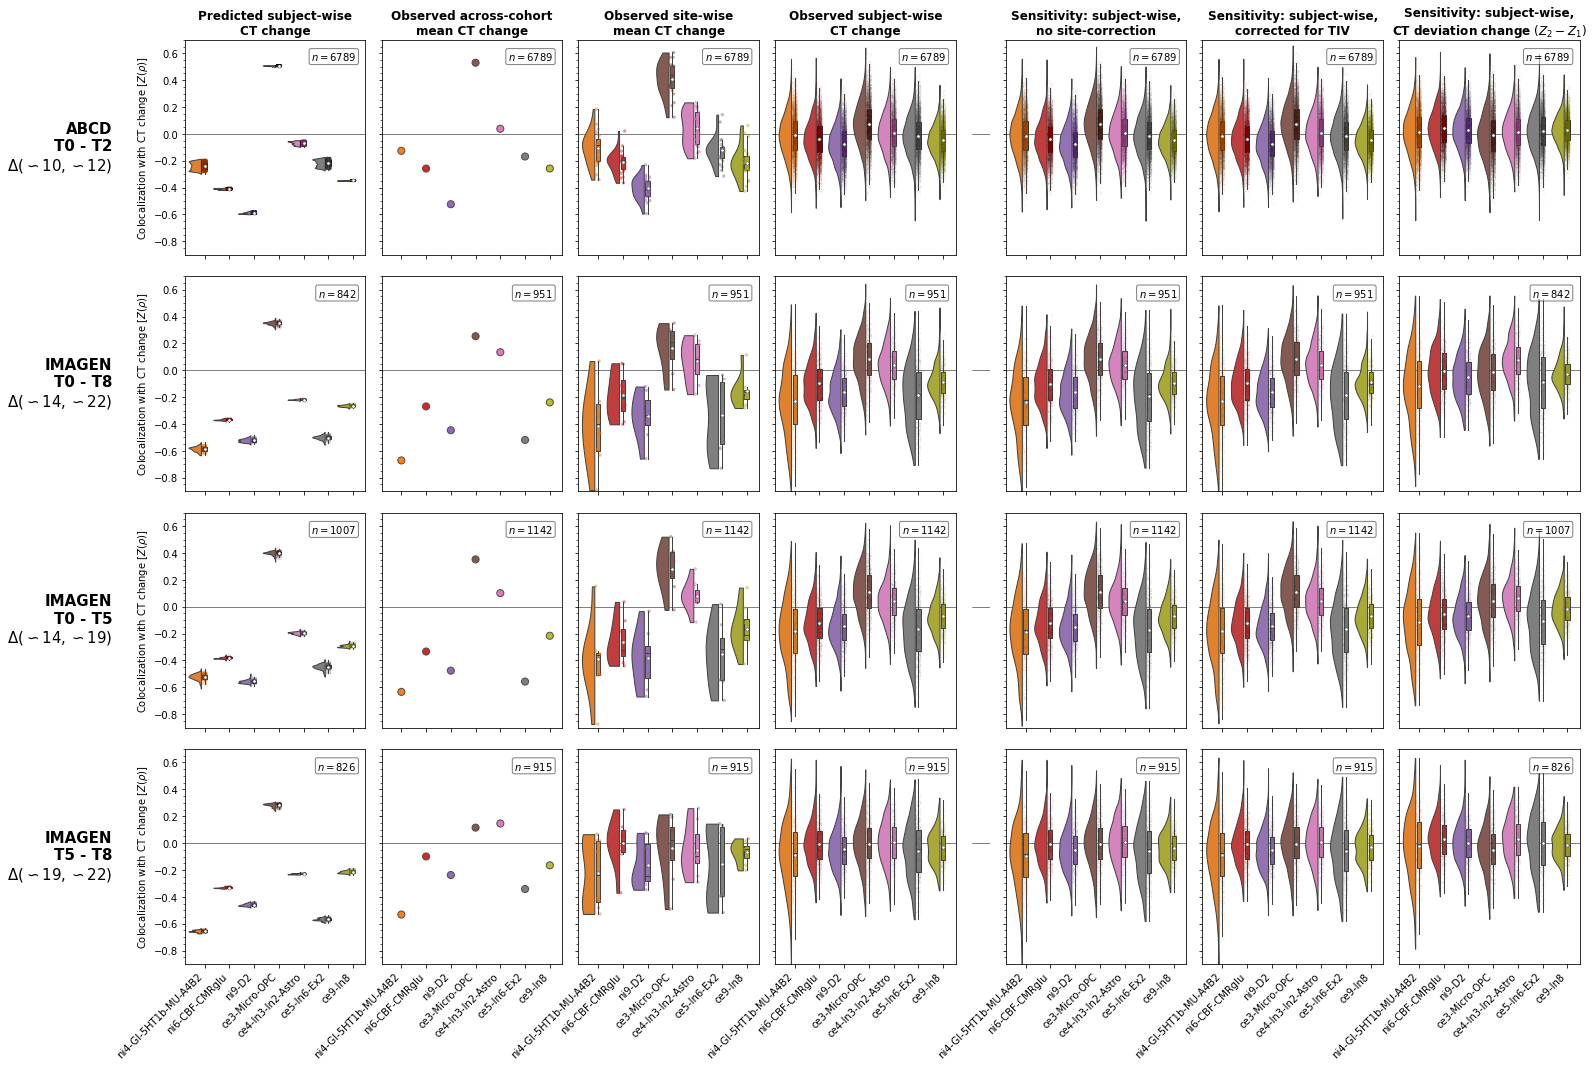

In [128]:
def label_n(n, ax):
    ax.annotate(
        f"$n={n}$",
        xy=(0.95, 0.95), xycoords="axes fraction", 
        va="top", ha="right", 
        bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.5)
    )
    
for analysis, pred, ylab, colors in zip(
    ["dominance", "spearman"],
    [["full_r2"] + predictors_both, ["spearman_"+p for p in predictors_both]],
    ["CT change explained [$adjusted\ R^2$]", "Colocalization with CT change "+r"[$Z(\rho)$]"],
    [np.vstack([c_full_model, c_predictors_both]), np.vstack([c_predictors_both])]
):
    
    # source data
    source_data = {}

    fig, axes = plt.subplots(n_ts, 8, figsize=(25,17), sharey="row", sharex="col",
                             gridspec_kw=dict(hspace=0.1, wspace=0.1, 
                                              width_ratios=(1,1,1,1, 0.1, 1,1,1)))
    
    for r, ds_ts, ts_age in zip(range(n_ts), ds_tss, tss_age):
        ds = ds_ts[0]
        ts = ds_ts[1]
        
        # predicted
        plot_raincloud(
            data=res_delta.loc[(ds, na(), ts, "delta_pred"), pred].melt(),
            x="variable",
            y="value",
            x_mean=range(len(pred)),
            y_mean=res_delta.loc[(ds, na(), ts, "delta_pred"), pred].mean(),
            ax=axes[r,0],
            ylab=ylab,
            colors=colors
        )
        label_n(res_delta.loc[(ds, na(), ts, 'delta_pred'), pred].shape[0], axes[r,0])
        axes[r,0].set_title("Predicted subject-wise\nCT change" if r==0 else "", weight="semibold")
        # source
        source_data[ds, ts, "predicted_subject"] = res_delta.loc[(ds, na(), ts, "delta_pred"), pred].describe()
        if analysis=="dominance":
            source_data[ds, ts, "predicted_subject"].loc["p"] = sig_delta_pred.loc[(ds, ts), :]
            source_data[ds, ts, "predicted_subject"].loc["q"] = mc_correction(sig_delta_pred.loc[(ds, ts), :])[0]
                
        # cohort mean
        sns.scatterplot(
            y=res_delta_allmean.loc[(ds, ts), pred],
            x=pred,
            ax=axes[r,1],
            c=colors,
            s=50,
            linewidth=1,
            edgecolor="0.3"
        )
        label_n(res_delta.loc[(ds, na(), ts, 'delta'), pred].shape[0], axes[r,1])
        axes[r,1].set_title("Observed across-cohort\nmean CT change" if r==0 else "", weight="semibold")
        axes[r,1].set_xlabel("")
        # source
        source_data[ds, ts, "observed_cohort"] = res_delta_allmean.loc[(ds, ts), pred].to_frame().T
        source_data[ds, ts, "observed_cohort"].index = ["mean"]
        if analysis=="dominance":
            source_data[ds, ts, "observed_cohort"].loc["p"] = sig_delta_allmean.loc[(ds, ts), :]
            source_data[ds, ts, "observed_cohort"].loc["q"] = mc_correction(sig_delta_allmean.loc[(ds, ts), :])[0]
        
        # site mean
        plot_raincloud(
            data=res_delta_sitemean.loc[(na(), ds, ts), pred].melt(),
            x="variable",
            y="value",
            x_mean=range(len(pred)),
            y_mean=res_delta_sitemean.loc[(na(), ds, ts), pred].mean(),
            ax=axes[r,2],
            colors=colors,
            scatter_a=0.5, scatter_s=3
        )
        label_n(res_delta.loc[(ds, na(), ts, 'delta'), pred].shape[0], axes[r,2])
        axes[r,2].set_title("Observed site-wise\nmean CT change" if r==0 else "", weight="semibold")
        # source
        source_data[ds, ts, "observed_site"] = res_delta_sitemean.loc[(na(), ds, ts), pred].describe()
        if analysis=="dominance":
            source_data[ds, ts, "observed_site"].loc["p"] = sig_delta_sitemean.loc[(ds, ts), :]
            source_data[ds, ts, "observed_site"].loc["q"] = mc_correction(sig_delta_sitemean.loc[(ds, ts), :])[0]
        
        # individual
        plot_raincloud(
            data=res_delta.loc[(ds, na(), ts, "delta"), pred].melt(),
            x="variable",
            y="value",
            x_mean=range(len(pred)),
            y_mean=res_delta.loc[(ds, na(), ts, "delta"), pred].mean(),
            ax=axes[r,3],
            colors=colors
        )
        label_n(res_delta.loc[(ds, na(), ts, 'delta'), pred].shape[0], axes[r,3])
        axes[r,3].set_title("Observed subject-wise\nCT change" if r==0 else "", weight="semibold")
        # source
        source_data[ds, ts, "observed_subject"] = res_delta.loc[(ds, na(), ts, "delta"), pred].describe()
        if analysis=="dominance":
            source_data[ds, ts, "observed_subject"].loc["p"] = sig_delta.loc[(ds, ts), :]
            source_data[ds, ts, "observed_subject"].loc["q"] = mc_correction(sig_delta.loc[(ds, ts), :])[0]
        
        # sensitivity analyses
        axes[r,4].set_axis_off()
        for i_sens, (sens_analysis, title) in enumerate(zip(
            ["delta_orig", "delta_tiv", "z_delta"],
            ["Sensitivity: subject-wise,\nno site-correction",
             "Sensitivity: subject-wise,\ncorrected for TIV",
             "Sensitivity: subject-wise,\nCT deviation change $(Z_2-Z_1)$"]
        )):
            plot_raincloud(
                data=res_delta.loc[(ds, na(), ts, sens_analysis), pred].melt(),
                x="variable",
                y="value",
                x_mean=range(len(pred)),
                y_mean=res_delta.loc[(ds, na(), ts, sens_analysis), pred].mean(),
                ax=axes[r,5+i_sens],
                colors=colors
            )
            label_n(res_delta.loc[(ds, na(), ts, sens_analysis), pred].shape[0], axes[r,5+i_sens])
            axes[r,5+i_sens].set_title(title if r==0 else "", weight="semibold")
            # source
            k = "observed_subject_noharmonization" if sens_analysis=="delta_orig" \
                else "observed_subject_tivcorrection" if sens_analysis=="delta_tiv" \
                else "observed_subject_deviationchange"
            source_data[ds, ts, k] = res_delta.loc[(ds, na(), ts, sens_analysis), pred].describe()
        
        # p values
        for c, (sig_df, max_df) in enumerate(zip(
            [sig_delta_pred, sig_delta_allmean, sig_delta_sitemean, sig_delta],
            [res_delta.loc[(ds, na(), ts, "delta_pred"), pred].max(),
             res_delta_allmean.loc[(ds, ts), pred],
             res_delta_sitemean.loc[(na(), ds, ts), pred].max(),
             res_delta.loc[(ds, na(), ts, "delta"), pred].max()]
        )):
            if (sig_df is not None) & (analysis!="spearman"):
                s = p_to_ast(pd.DataFrame(sig_df.loc[(ds, ts)]), mc_correction(sig_df.loc[(ds, ts), :]))
                for i, p in enumerate(pred):
                    axes[r,c].text(
                        s=s.iloc[i].values[0],
                        x=i,
                        y=max_df[i] + (0.015 if c!=1 else 0.03),
                        size=15,
                        c=colors[i],
                        ha="center"                     
                    )
        
        # dataset & timespan
        axes[r,0].annotate(
            f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n"
            f"{ts[:2]} - {ts[2:]}\n" 
            r"$\Delta(\backsim$" + f"${ts_age[0]},$" + r"$\backsim$" + f"${ts_age[1]})$",
            xy=(-0.4,0.5), xycoords="axes fraction", rotation=0, weight="semibold",
            size=15, va="center", ha="right"
        )
        
        # layout
        for c in range(8):
            
            axes[r,c].set_xlim([-0.8, len(pred)-0.5])
            axes[r,c].set_xticks(range(len(pred)))
            
            if analysis=="dominance":
                axes[r,c].set_ylim([-0.02, 0.66])
                axes[r,c].set_yticks(np.arange(0, 0.66, 0.1))
                axes[r,c].set_yticks(np.arange(0, 0.66, 0.02), minor=True)
                axes[r,c].set_xticklabels(["Full model"] + predictors_both, rotation=45, ha="right")
                
            elif analysis=="spearman":
                axes[r,c].set_ylim([-0.9, 0.7])
                axes[r,c].set_yticks(np.arange(-0.8, 0.62, 0.2))
                axes[r,c].set_yticks(np.arange(-0.85, 0.72, 0.05), minor=True)
                axes[r,c].set_xticklabels(replace(pred, "spearman_"), rotation=45, ha="right")
                axes[r,c].axhline(0, c="k", lw=0.5, zorder=0)

    plt.savefig(join(plot_dir, f"dev_delta_full_{analysis}.png"), bbox_inches="tight", dpi=600)
    plt.show()
    # source
    pd.concat(source_data, names=["ds", "ts", "analysis", "stat"]) \
        .to_csv(join(plot_dir, f"dev_delta_full_{analysis}_source.csv"))

#### Do subject-level models transfer from Braincharts to true data?
"One size fits all?"

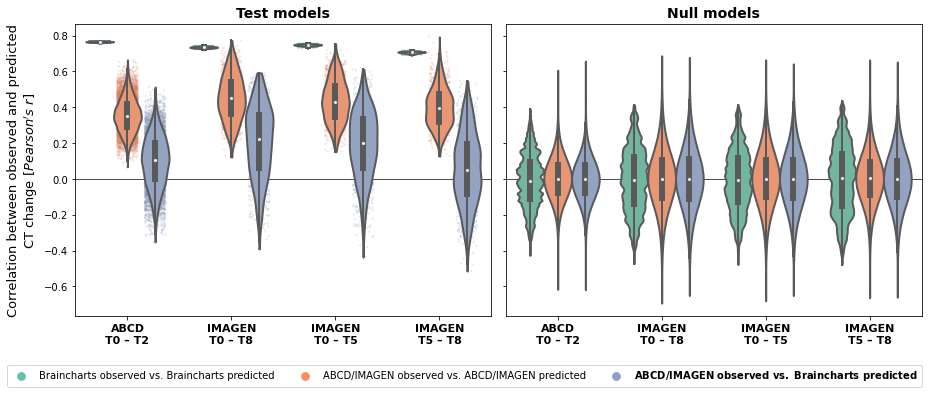

In [157]:
# prepare dataframes
res_transpred_melt = res_transpred \
    .reset_index() \
    .melt(id_vars=["ds", "id", "ts"])
res_transpred_null_melt = res_transpred_null \
    .reset_index() \
    .melt(id_vars=["ds", "id", "ts", "i"])
    

# plot
fig, axes = plt.subplots(1,2, figsize=(13,5), sharex=True, sharey=True)
colors = sns.color_palette("Set2", 3)

for c, (data, title) in enumerate(zip([res_transpred_melt, res_transpred_null_melt], 
                                      ["Test models", "Null models"])):
    
    if title=="Test models":
        sns.stripplot(
            data=data,
            y="value",
            x="ts",
            hue="variable",
            dodge=True,
            zorder=1,
            palette=colors,
            linewidth=0.1,
            size=2,
            alpha=0.2,
            jitter=0.3,
            ax=axes[c],
        )
    sns.violinplot(
        data=data,
        y="value",
        x="ts",
        hue="variable",
        zorder=10,
        linewidth=2,
        palette=colors,
        scale="width",
        cut=0,
        ax=axes[c],
    )
    
    axes[c].legend().remove()
    axes[c].axhline(0, c="0.3", zorder=0, lw=1)
    axes[c].set_xlabel("")
    axes[c].set_xticklabels([f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n{ts[:2]} – {ts[2:]}" for ds, ts in ds_tss], 
                            ha="center", weight="semibold", size=11)
    axes[c].set_ylabel("")
    axes[c].set_title(title, weight="semibold", size=14)
    
axes[0].set_ylabel("Correlation between observed and predicted\nCT change $[Pearson's\ r]$", 
                   size=13)

handles, labels = axes[0].get_legend_handles_labels()
labels[2] = r"$\bf{ABCD/IMAGEN\ observed\ vs.\ Braincharts\ predicted}$"
leg = fig.legend(handles[:3], labels[:3], ncol=3, loc="lower center", bbox_to_anchor=(0.5,-0.1))

fig.tight_layout()

plt.savefig(join(plot_dir, f"dev_delta_transfer.png"), bbox_inches="tight", dpi=300)

# source
pd.concat(
    {"observed": pd.concat(
        {c: res_transpred[c].groupby(["ds", "ts"]).describe() 
         for c in res_transpred.columns},
        names=["analysis", "dataset", "timespan"]
    ),
     "null": pd.concat(
         {c: res_transpred_null[c].groupby(["ds", "ts"]).describe() 
          for c in res_transpred_null.columns},
         names=["analysis", "dataset", "timespan"]
    )}
) \
    .to_csv(join(plot_dir, f"dev_delta_transfer_source.csv"))


#### Systematic influences on CT explanation

In [158]:
# function to plot scatter and distribution
def plot_scattercloud(x, y, ax1, ax2, ax1_xlab="", ax2_xlab="", annot="right", color=None):
    sns.scatterplot(x=x.iloc[:,0], y=y, ax=ax1,
                    alpha=0.1,
                    size=20,
                    legend=False,
                    color=color)
    r, p = spearmanr(x,y, nan_policy="omit")
    p = f"p={p:.03f}" if p >= 0.001 else "p<0.001"
    n = (~np.isnan(np.squeeze(x)) & ~np.isnan(np.squeeze(y))).sum()
    ax1.annotate(
        fr"$n = {n}$" + "\n" + fr"$\rho={r:.02f}$" + "\n" + fr"${p}$", 
        xy=(0.05 if annot=="left" else 0.95, 0.95), 
        xycoords="axes fraction", 
        ha=annot,
        va="top",
        bbox=dict(boxstyle="round, pad=0.2", fc="white", ec=color, alpha=0.5))
    ax1.set_xlabel(ax1_xlab)
    ax1.set_ylabel("")
    plot_raincloud(
        data=x.melt(),
        y="variable",
        x="value",
        x_mean=x.mean(),
        y_mean=0,
        ax=ax2,
        xlab=ax2_xlab,
        colors=None if color==None else [color] 
    )
    ax2.set_ylim(-0.8,0.2)
    ax2.set_yticks([])

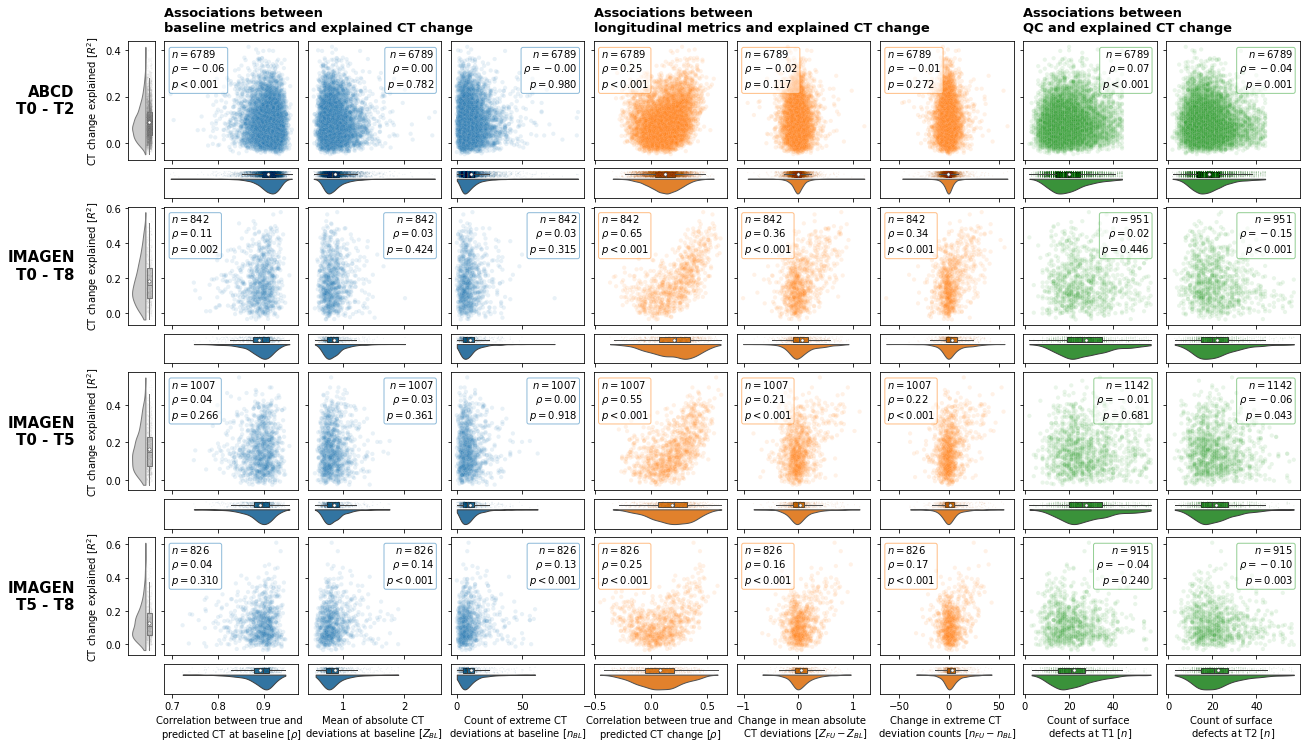

In [176]:
# source data
source_data = {}

fig, axes = plt.subplots(2*n_ts, 1+8, figsize=(21,12), sharey="row", sharex="col",
                         gridspec_kw=dict(
                             width_ratios=(0.2, 1,1,1,1,1,1,1,1), 
                             height_ratios=[1, 0.25] * n_ts,
                             wspace=0.08,
                             hspace=0.12))

for r, ds_ts in zip(range(0, 2*n_ts, 2), ds_tss):
    ds = ds_ts[0]
    ts = ds_ts[1]
    subs = data_delta.loc[(ds, na(), ts), "id"].to_list()
    
    # R2 distribution
    plot_raincloud(
        data=res_delta.loc[(ds, subs, ts, "delta"), ["full_r2"]].melt(),
        x="variable",
        y="value",
        x_mean=0,
        y_mean=[res_delta.loc[(ds, subs, ts, "delta"), "full_r2"].mean()],
        ax=axes[r,0],
        ylab="CT change explained [$R^2$]",
        colors=[c_full_model]
    )
    #axes[0,0].set_yticks(np.arange(0,0.5,0.02), minor=True)
    axes[r,0].set_xlim(-0.8,0.2)
    axes[r,0].set_xticks([])
    axes[r+1,0].axis("off")
    
    # surface defects
    df_defects = abcd[["apqc_smri_topo_ndefect"]] if ds=="abcd" else imgn[["SurfaceHoles"]]

    # source
    source_data[ds, ts, "CT change explained"] = res_delta.loc[(ds, subs, ts, "delta"), "full_r2"].describe()
    
    # Scatters
    y = res_delta.loc[(ds, subs, ts, "delta"), "full_r2"].reset_index(drop=True)

    for c, (x_lab, x, color, annot_site) in enumerate(zip(
        ["Correlation between true and \npredicted CT at baseline " + r"[$\rho$]",
         "Mean of absolute CT \ndeviations at baseline " + r"[$Z_{BL}$]",
         "Count of extreme CT \ndeviations at baseline " + r"[$n_{BL}$]",
         "Correlation between true and \npredicted CT change " + r"[$\rho$]",
         "Change in mean absolute \n CT deviations " + r"[$Z_{FU}-Z_{BL}$]",
         "Change in extreme CT \ndeviation counts " + r"[$n_{FU}-n_{BL}$]",
         "Count of surface \ndefects at T1 [$n$]",
         "Count of surface \ndefects at T2 [$n$]"],
        [data_cross.loc[(ds, subs, ts[:2]), ["summary-cor_pred_cross"]].reset_index(drop=True),
         data_cross.loc[(ds, subs, ts[:2]), ["summary-mean_abs_z"]].reset_index(drop=True),
         data_cross.loc[(ds, subs, ts[:2]), ["summary-n_extr_z"]].reset_index(drop=True),
         data_delta.loc[(ds, subs, ts), ["summary-cor_pred_delta"]].reset_index(drop=True),
         data_delta.loc[(ds, subs, ts), ["summary-diff_mean_abs_z"]].reset_index(drop=True),
         data_delta.loc[(ds, subs, ts), ["summary-diff_n_extr_z"]].reset_index(drop=True),
         df_defects.loc[(subs, ts[:2]), ].reset_index(drop=True),
         df_defects.loc[(subs, ts[2:]), ].reset_index(drop=True)],
        ["tab:blue"]*3 + ["tab:orange"]*3 + ["tab:green"]*2, 
        ["left", "right", "right", "left", "left", "left", "right", "right"]
    ), start=1):
    
        plot_scattercloud(
            x=x,
            y=y,
            ax1=axes[r, c], 
            ax2=axes[r+1, c], 
            color=color,
            annot=annot_site,
            ax2_xlab=x_lab
        )
        
        # source 
        source_data[ds, ts, x_lab] = x.describe()
        source_data[ds, ts, x_lab].loc["CTchangeCorr_rho"], source_data[ds, ts, x_lab].loc["CTchangeCorr_p"] = \
            spearmanr(x, y, nan_policy="omit")
    
    # dataset & timespan
    axes[r,0].annotate(
        f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n"
        f"{ts[:2]} - {ts[2:]}",
        xy=(-2,0.5), xycoords="axes fraction", 
        weight="semibold", size=15, va="center", ha="right"
    )
        
# Layout
[axes[0, c].set_title(
    f"Associations between\n{title} and explained CT change", loc="left", weight="semibold", pad=10, size=13) \
 for c, title in zip([1, 4, 7], ["baseline metrics", "longitudinal metrics", "QC"])]    

# remove all x labels except for the lowest row (no idea why we have do to this)
_ = [axes[r,c].set_xlabel("") for r in range(axes.shape[0]-1) for c in range(axes.shape[1])]

plt.savefig(join(plot_dir, f"dev_deviation_associations.png"), bbox_inches="tight", dpi=400)

# source
source_data = pd.concat(source_data, names=["dataset", "timespan", "analysis"], axis=1).T
source_data.index = source_data.index.droplevel(-1)
source_data.to_csv(join(plot_dir, f"dev_deviation_associations_source.csv"))

#### Does CT change prediction vary by follow-up duration?

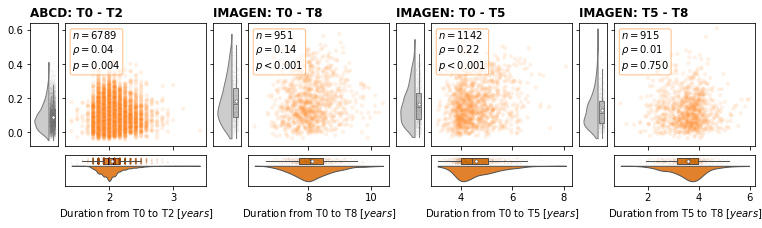

In [181]:
# source data
source_data = {}

fig, axes = plt.subplots(2, n_ts*2, figsize=(13,3), sharey="row",
                         gridspec_kw=dict(width_ratios=(0.2,1, 0.2,1, 0.2,1, 0.2,1),
                                          height_ratios=[1, 0.25],
                                          wspace=0.08,
                                          hspace=0.12))

for c, (ds, ts) in zip(range(0, n_ts*2, 2), ds_tss):
    subs = data_delta.loc[(ds, na(), ts), "id"].to_list()
    df = abcd if ds=="abcd" else imgn
    y = res_delta.loc[(ds, subs, ts, "delta"), ["full_r2"]]
    
    # R2 distribution
    plot_raincloud(
        data=y.melt(),
        x="variable",
        y="value",
        x_mean=0,
        y_mean=[res_delta.loc[(ds, subs, ts, "delta"), "full_r2"].mean()],
        ax=axes[0,c],
        ylab="CT change explained [$R^2$]" if r==0 else "",
        colors=[c_full_model]
    )
    axes[0,c].set_xlim(-0.8,0.2)
    axes[0,c].set_xticks([])
    axes[1,c].set_axis_off()
    
    # source
    source_data[ds, ts, "CT change explained"] = res_delta.loc[(ds, subs, ts, "delta"), ["full_r2"]].describe()

    x = df[["age"]].copy()
    x.loc[(subs, ts[2:]), "age_diff"] = df.loc[(subs, ts[2:]), "age"].values - df.loc[(subs, ts[:2]), "age"].values
    x = x.loc[(subs, ts[2:]), ["age_diff"]]
    y = y["full_r2"]
    plot_scattercloud(
        x=x.reset_index(drop=True),
        y=y.reset_index(drop=True),
        ax1=axes[0, c+1], 
        ax2=axes[1, c+1], 
        color="tab:orange",
        annot="left",
        ax2_xlab=f"Duration from {ts[:2]} to {ts[2:]} $[years]$"
    )
    axes[0, c+1].set_xlabel("")
    axes[0, c+1].set_xticklabels([])
    
    axes[0,c].set_title(f"{'ABCD' if ds=='abcd' else 'IMAGEN'}: {ts[:2]} - {ts[2:]}", 
                        weight="semibold", loc="left")
    
    # source 
    source_data[ds, ts, x_lab] = x.loc[(subs, ts[2:]), ["age_diff"]].reset_index(drop=True).describe()
    source_data[ds, ts, x_lab].loc["CTchangeCorr_rho"], source_data[ds, ts, x_lab].loc["CTchangeCorr_p"] = \
        spearmanr(x, y, nan_policy="omit")
    
plt.savefig(join(plot_dir, f"dev_fu_duration.png"), bbox_inches="tight", dpi=300)

# source data
source_data = pd.concat(source_data, names=["dataset", "timespan", "analysis"], axis=1).T
source_data.index = source_data.index.droplevel(-1)
source_data.to_csv(join(plot_dir, f"dev_fu_duration_source.csv"))

#### Does CT change prediction vary by sex or site?

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_3341/2333970616.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_3341/2333970616.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],


    Group A Group B     T      df  p-FDR     g
0      CHLA     CUB  2.67  357.80  0.041  0.24
1      CHLA     FIU  2.94  344.83  0.023  0.28
2      CHLA    LIBR  1.53  305.42  0.279  0.14
3      CHLA    MUSC -0.57  414.91  0.747 -0.05
4      CHLA    OHSU  3.43  322.26  0.007  0.33
..      ...     ...   ...     ...    ...   ...
205     UWM   WUSTL  0.10  323.39  0.955  0.01
206     UWM    YALE -1.54  380.21  0.276 -0.14
207     VCU   WUSTL  2.01  545.65  0.143  0.15
208     VCU    YALE  0.11  584.65  0.955  0.01
209   WUSTL    YALE -2.03  765.31  0.140 -0.14

[210 rows x 6 columns]


/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_3341/2333970616.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_3341/2333970616.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],


       Group A     Group B      T      df    p-FDR     g
0       Berlin     Dresden  -0.52  185.59    0.650 -0.07
1       Berlin      Dublin  -4.92  135.60  < 0.001 -0.72
2       Berlin     Hamburg -14.87  251.50  < 0.001 -1.78
3       Berlin      London  -2.15  266.16    0.040 -0.26
4       Berlin    Mannheim  -6.57  206.79  < 0.001 -0.85
5       Berlin  Nottingham  -2.31  288.89    0.028 -0.27
6       Berlin       Paris -17.56  227.66  < 0.001 -2.19
7      Dresden      Dublin  -4.15  158.94  < 0.001 -0.62
8      Dresden     Hamburg -12.64  220.28  < 0.001 -1.63
9      Dresden      London  -1.26  173.84    0.233 -0.18
10     Dresden    Mannheim  -5.30  193.91  < 0.001 -0.75
11     Dresden  Nottingham  -1.41  180.85    0.188 -0.19
12     Dresden       Paris -15.01  208.24  < 0.001 -2.03
13      Dublin     Hamburg  -6.28  171.87  < 0.001 -0.87
14      Dublin      London   3.56  130.94  < 0.001  0.54
15      Dublin    Mannheim  -0.16  160.44    0.875 -0.02
16      Dublin  Nottingham   3.

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_3341/2333970616.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_3341/2333970616.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],


       Group A     Group B      T      df    p-FDR     g
0       Berlin     Dresden  -1.76  255.96    0.102 -0.22
1       Berlin      Dublin  -6.36  168.40  < 0.001 -0.89
2       Berlin     Hamburg  -6.41  269.88  < 0.001 -0.76
3       Berlin      London  -1.62  251.35    0.125 -0.20
4       Berlin    Mannheim  -3.61  234.55  < 0.001 -0.47
5       Berlin  Nottingham  -2.71  269.45    0.011 -0.31
6       Berlin       Paris -12.59  299.97  < 0.001 -1.37
7      Dresden      Dublin  -4.97  172.00  < 0.001 -0.69
8      Dresden     Hamburg  -4.53  278.82  < 0.001 -0.53
9      Dresden      London   0.30  260.39    0.765  0.04
10     Dresden    Mannheim  -1.81  242.24    0.096 -0.23
11     Dresden  Nottingham  -0.78  278.93    0.450 -0.09
12     Dresden       Paris -10.68  309.35  < 0.001 -1.16
13      Dublin     Hamburg   1.64  163.08    0.125  0.23
14      Dublin      London   5.45  150.87  < 0.001  0.77
15      Dublin    Mannheim   3.62  164.85  < 0.001  0.52
16      Dublin  Nottingham   4.

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_3341/2333970616.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_3341/2333970616.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],


       Group A     Group B     T      df    p-FDR     g
0       Berlin     Dresden -1.31  202.88    0.228 -0.18
1       Berlin      Dublin -2.20  169.78    0.043 -0.32
2       Berlin     Hamburg -9.78  191.77  < 0.001 -1.22
3       Berlin      London -3.04  220.85    0.005 -0.40
4       Berlin    Mannheim -4.14  218.31  < 0.001 -0.54
5       Berlin  Nottingham -3.92  241.21  < 0.001 -0.49
6       Berlin       Paris -7.12  200.44  < 0.001 -0.94
7      Dresden      Dublin -0.93  177.55    0.394 -0.14
8      Dresden     Hamburg -8.61  201.51  < 0.001 -1.08
9      Dresden      London -1.61  216.40    0.146 -0.22
10     Dresden    Mannheim -2.77  219.98    0.010 -0.37
11     Dresden  Nottingham -2.44  231.81    0.024 -0.31
12     Dresden       Paris -5.81  208.45  < 0.001 -0.77
13      Dublin     Hamburg -7.60  203.70  < 0.001 -0.96
14      Dublin      London -0.55  180.15    0.607 -0.08
15      Dublin    Mannheim -1.71  193.52    0.125 -0.24
16      Dublin  Nottingham -1.32  187.52    0.22

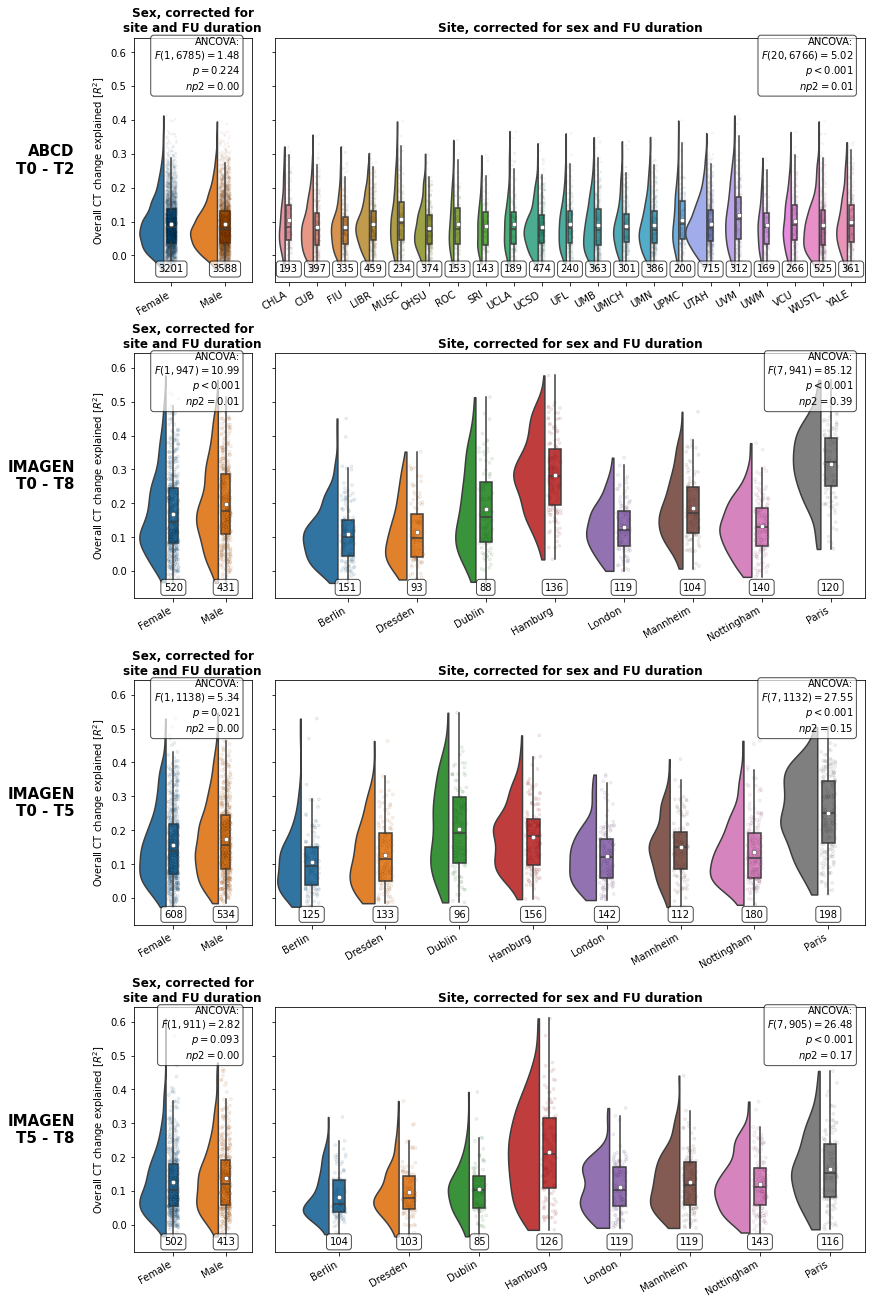

In [202]:
pw_tests = list()

# source data
source_data = {}

fig, axes = plt.subplots(len(ds_tss), 2, figsize=(12,18), constrained_layout=True,
                         gridspec_kw=dict(width_ratios=(0.4,2)), sharey=True)

for r, (ds, ts) in enumerate(ds_tss):
    df = abcd if ds=="abcd" else imgn
        
    temp = res_delta.loc[(ds, na(), ts, "delta"), ["full_r2"]]
    temp["sex"] = df.loc[(temp.index.get_level_values("id"), ts[:2]), "sex_str"].values
    temp["sex_num"] = df.loc[(temp.index.get_level_values("id"), ts[:2]), "sex"].values
    temp["site"] = df.loc[(temp.index.get_level_values("id"), ts[:2]), "site_str"].values
    temp["site_num"] = df.loc[(temp.index.get_level_values("id"), ts[:2]), "site"].values
    temp["age_diff"] = df.loc[(temp.index.get_level_values("id"), ts[2:]), "age"].values - \
        df.loc[(temp.index.get_level_values("id"), ts[:2]), "age"].values
    temp.site = [s.title() for s in temp.site] if ds=="imgn" else temp.site
    temp = temp.melt(["sex", "site", "sex_num", "site_num", "age_diff"])
    
    temp = temp.replace({
        "M": "Male",
        "F": "Female"
    })
   
    n = temp.groupby("site").count()["value"].sort_index(ascending=True)
    temp.index = pd.Index(temp.site, name="idx")
    idx_ordered = n.index
    temp = temp.loc[idx_ordered.tolist(),]
    
    # plot
    for c, (x_lab, y_lab, order, title) in enumerate(zip(
        ["sex", "site"],
        ["full_r2", "full_r2"],
        [["Female", "Male"], idx_ordered],
        ["Sex, corrected for\nsite and FU duration", "\nSite, corrected for sex and FU duration"]
    )):
        
        plot_raincloud(
            data=temp[temp.variable==y_lab],
            ax=axes[r,c],
            x=x_lab,
            y="value",
            y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],
            x_mean=range(len(order)),
            violin_scale="count",
            violin_w=1.5 if (ds=="abcd") & (x_lab!="sex") else 1,
            violinbox_lw=1.5,
            scatter_a=0.05 if ds=="abcd" else 0.1,
            scatter_s=2 if ds=="abcd" else 3,
            scatter_lw=0.5,
            mean_s=20
        )
        
        axes[r,c].set_title(title, weight="semibold")
        if c==0:
            axes[r,c].set_ylabel("Overall CT change explained [$R^2$]")
            # dataset & timespan
            axes[r,c].annotate(
                f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n"
                f"{ts[:2]} - {ts[2:]}",
                xy=(-0.5,0.5), xycoords="axes fraction", 
                weight="semibold", size=15, va="center", ha="right"
            )
        
        # sample size
        n_sub = temp[temp.variable==y_lab].groupby(x_lab).count().loc[order, "value"]
        for i, lab in enumerate(order):
            axes[r,c].text(
                s=f"{n_sub[i]}",
                y=axes[r,c].get_ylim()[0] + 0.02,
                x=i,
                ha="center",
                bbox=dict(boxstyle="round", facecolor='w', alpha=0.7)
            )
                
        anc = ancova(
            data=temp[temp.variable==y_lab],
            dv="value",
            between=x_lab,
            covar=["site_num", "age_diff"] if x_lab=="sex" else ["sex_num", "age_diff"]
        )
        p = anc['p-unc'].values[0]
        s = "ANCOVA:\n" \
            f"$F({anc.DF.values[0]},{anc.DF.values[-1]}) = {anc.F.values[0]:.02f}$\n " \
            f"$p{'<0.001' if p < 0.001 else '='+str(p.round(3))}$\n " \
            f"$np2={anc.np2.values[0]:.02f}$"
               
        axes[r,c].text(
            s=s,
            y=0.79,
            x=0.9 if x_lab=="sex" else 0.98,
            ha="right",
            bbox=dict(boxstyle="round", facecolor='w', alpha=0.7),
            transform=axes[r,c].transAxes
        )
        
        # pairwise table
        if (x_lab!="sex") & (p < 0.05):
            
            pw = pairwise_tests(
                data=temp[temp.variable==y_lab],
                dv="value",
                between=x_lab,
                padjust="fdr_bh"
            )

            pw = pw.rename(columns={
                "A": "Group A",
                "B": "Group B",
                "dof": "df",
                "p-corr": "p-FDR",
                "hedges": "g"
            })
            pw = pw[["Group A", "Group B", "T", "df", "p-FDR", "g"]]
            pw[["T", "df", "g"]] = pw[["T", "df", "g"]].round(2)
            pw["p-FDR"] = ["< 0.001" if p < 0.001 else f"{p:.03f}" for p in pw["p-FDR"]]
            pw_tests.append(pw)
            print(pw)
            
        # source data
        source_data[ds, ts, x_lab] = temp[temp.variable==y_lab].groupby(x_lab)["value"].describe()

        
_ = [ax.set_xticklabels(ax.get_xticklabels(), ha="right", rotation=30) for ax in axes.ravel()]

plt.savefig(join(plot_dir, f"dev_sex_site.png"), bbox_inches="tight", dpi=400)

# source data
pd.concat(source_data, names=["dataset", "timespan", "analysis", "group_level"]) \
    .to_csv(join(plot_dir, f"dev_sex_site_source.csv"))